# Thesis Analysis Notebook

**Julie Demuth – BSc Thesis 2025**  
Detecting Network Externalities in Preschool Social Networks

This notebook contains all code used to generate the interaction networks, figures, and structural test results presented in the thesis.  
Data: Fasano et al. (2021) — [OSF dataset](https://osf.io/84fwc/?view_only=306f65dcd1144d92b2bc87a185165c25)  
Method inspiration: Graham & Pelican (2020) — [Code repo](https://github.com/bryangraham/Testing_Networks)



# Section 1: Data Preprocessing & Diagnosis Mapping

Install and Import Required Packages

In [2]:
# Install required packages
!pip install python-igraph cairocffi --quiet

# Imports
import pandas as pd
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from datetime import datetime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.2 MB/s eta 0:00:00


Load and Inspect the Data

In [5]:
# Load interaction dataset
df = pd.read_csv("partner vocalizations.csv")
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')

# Quick data check
print("Observation date range:", df["Date"].min(), "to", df["Date"].max())
print(df["Date"].dt.to_period('M').value_counts().sort_index())



Observation date range: 2019-01-23 00:00:00 to 2020-02-18 00:00:00
Date
2019-01    278
2019-02    144
2019-03    318
2019-04    260
2019-05    184
2019-11    110
2019-12    306
2020-01    396
2020-02    436
Freq: M, Name: count, dtype: int64


Add Dyad Key and Diagnosis Mapping

In [6]:
# Create DyadKey (unordered pair of Subject and Partner)
df["DyadKey"] = df.apply(lambda row: tuple(sorted((row["Subject"], row["Partner"]))), axis=1)

# Build diagnosis mapping dictionary
diagnosis_map = {}
for idx, row in df.iterrows():
    diagnosis_map[row["Subject"]] = row["specificdiagnosis"].strip().title()
    diagnosis_map[row["Partner"]] = row["partnerspecificdiagnosis"].strip().title()


Split Dataset by Time Periods



In [7]:
# Halves based on median date
median_date = df["Date"].median()
first_half = df[df["Date"] <= median_date].copy()
second_half = df[df["Date"] > median_date].copy()

# Thirds (chronologically sorted)
df_sorted = df.sort_values("Date")
third_len = len(df_sorted) // 3
first_third = df_sorted.iloc[:third_len].copy()
second_third = df_sorted.iloc[third_len:2*third_len].copy()
third_third = df_sorted.iloc[2*third_len:].copy()


# Section 2: Network Construction (0, 3+, 5+, 10+ Thresholds)

Define the Graph Construction Function

In [13]:
def generate_network(dataframe, threshold, label):
    dyad_counts = dataframe.groupby("DyadKey").size().reset_index(name="InteractionCount")
    dyad_filtered = dyad_counts[dyad_counts["InteractionCount"] >= threshold]
    all_ids = sorted(set(dataframe["Subject"]) | set(dataframe["Partner"]))

    # Adjacency matrix
    adj_matrix = pd.DataFrame(0, index=all_ids, columns=all_ids)
    for i, j in dyad_filtered["DyadKey"]:
        adj_matrix.loc[i, j] = 1
        adj_matrix.loc[j, i] = 1
    adj_matrix.to_csv(f"adjacency_matrix_{label}.csv")

    # Node metadata
    metadata = pd.DataFrame({
        "ID": all_ids,
        "Diagnosis": [diagnosis_map.get(x, "Unknown") for x in all_ids]
    })
    metadata.to_csv(f"nodes_metadata_{label}.csv", index=False)

    # Degree centrality
    deg_cent = adj_matrix.sum(axis=1)
    centrality_df = pd.DataFrame({
        "ID": deg_cent.index,
        "Degree": deg_cent.values,
        "Diagnosis": [diagnosis_map.get(x, "Unknown") for x in deg_cent.index]
    })
    centrality_df.to_csv(f"degree_centrality_{label}.csv", index=False)

    # Graph construction
    nodes = list(adj_matrix.index)
    edges = [(i, j) for i in nodes for j in nodes if adj_matrix.loc[i, j] == 1 and i < j]

    g = ig.Graph()
    g.add_vertices(nodes)
    g.add_edges(edges)
    g.vs["diagnosis"] = [diagnosis_map.get(v["name"], "Unknown") for v in g.vs]
    color_dict = {"Autism": "red", "Delay": "green", "Typical": "blue"}
    g.vs["color"] = [color_dict.get(d, "gray") for d in g.vs["diagnosis"]]
    g.vs["size"] = [10 if d == 0 else 12 + d * 1.5 for d in g.degree()]

    layout = g.layout_kamada_kawai()
    scaled_layout = [(x * 1.8, y * 1.8) for x, y in layout]

    fig, ax = plt.subplots(figsize=(18, 15))
    ig.plot(
        g,
        target=ax,
        layout=scaled_layout,
        vertex_size=g.vs["size"],
        vertex_color=g.vs["color"],
        vertex_label=None,
        edge_color="black",
        edge_width=1.0,
    )
    plt.axis("off")
    legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='ASD', markerfacecolor='red', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='DD', markerfacecolor='green', markersize=12),
    Line2D([0], [0], marker='o', color='w', label='TD', markerfacecolor='blue', markersize=12),
    ]
    plt.legend(handles=legend_elements, loc='lower left')

    plt.title(f"Network ({label.replace('_', ' ').title()})", fontsize=18)
    plt.show()


# Section 3: Network Visualization

Generate Graphs — No Interaction Threshold

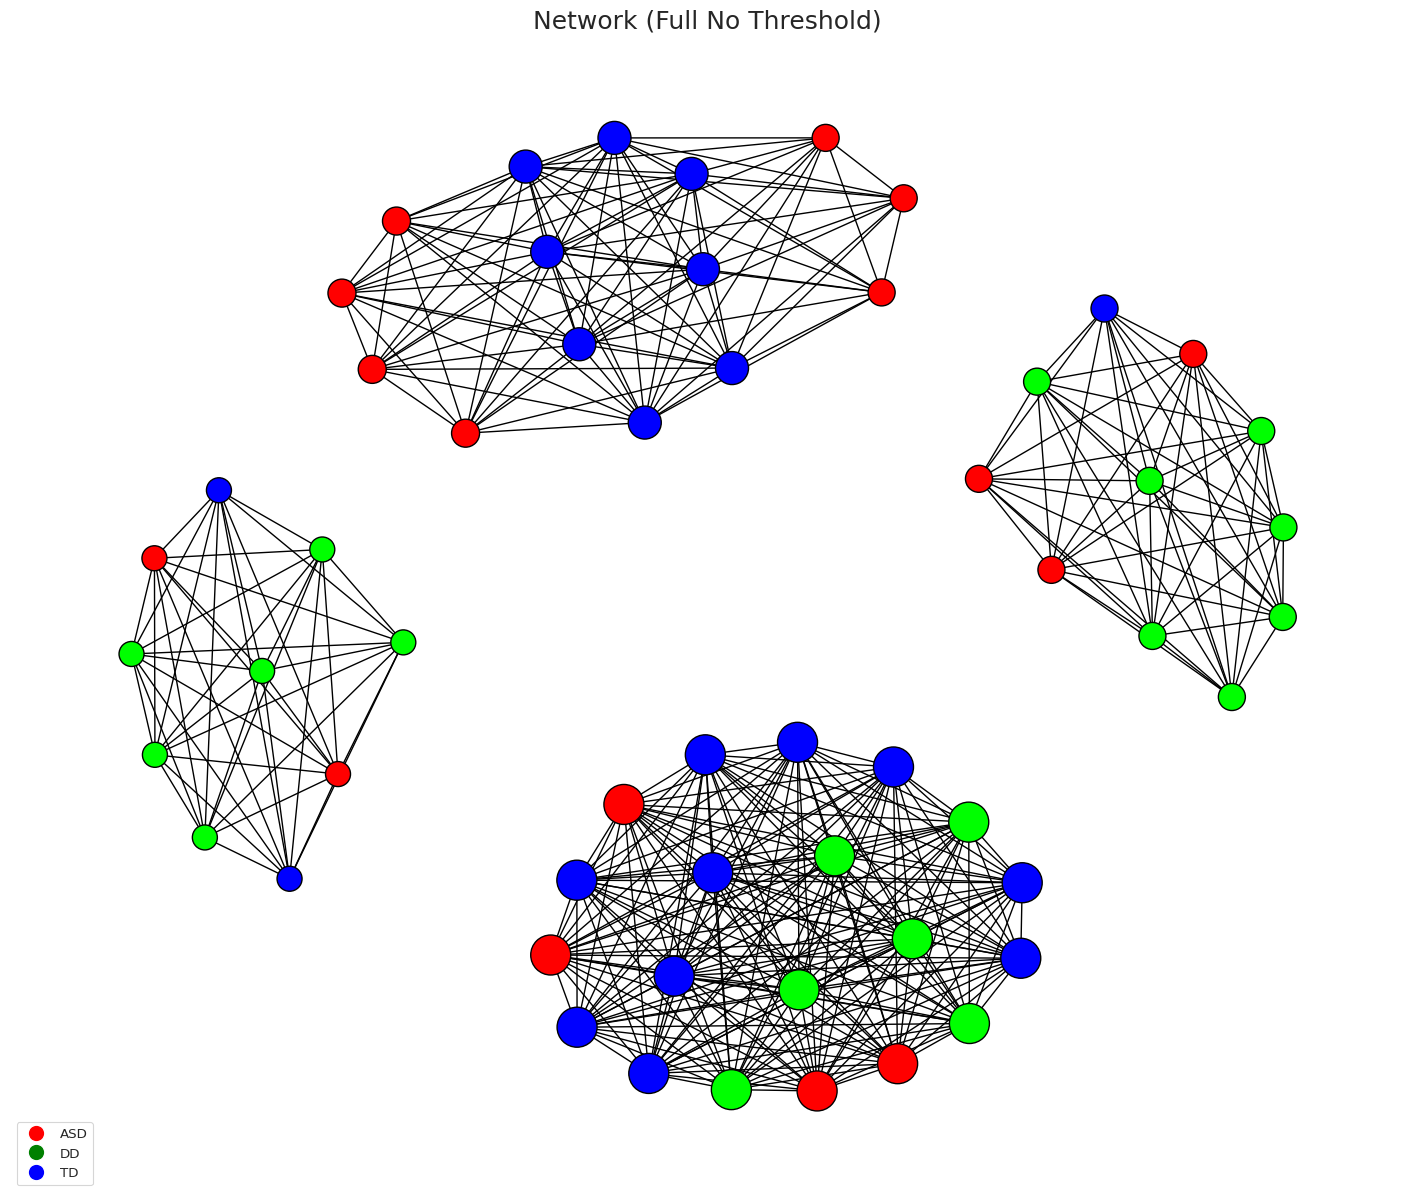

In [9]:
generate_network(df, threshold=0, label="full_no_threshold")

Generate Graphs — 5+ Interaction Threshold

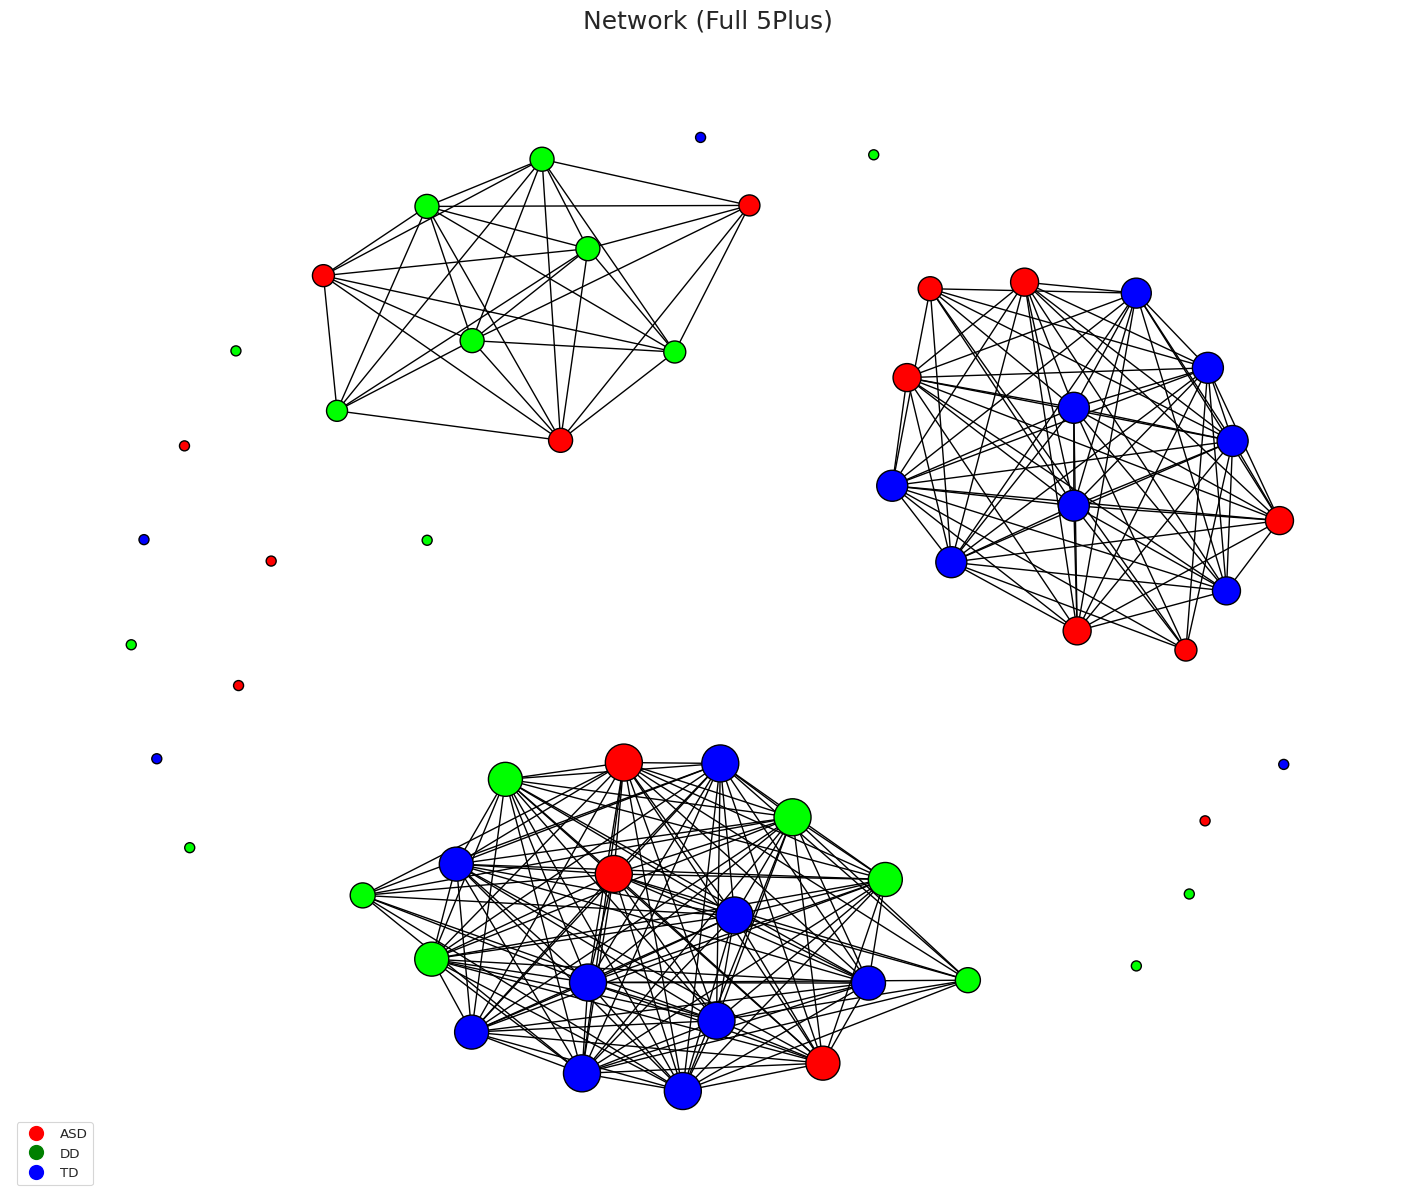

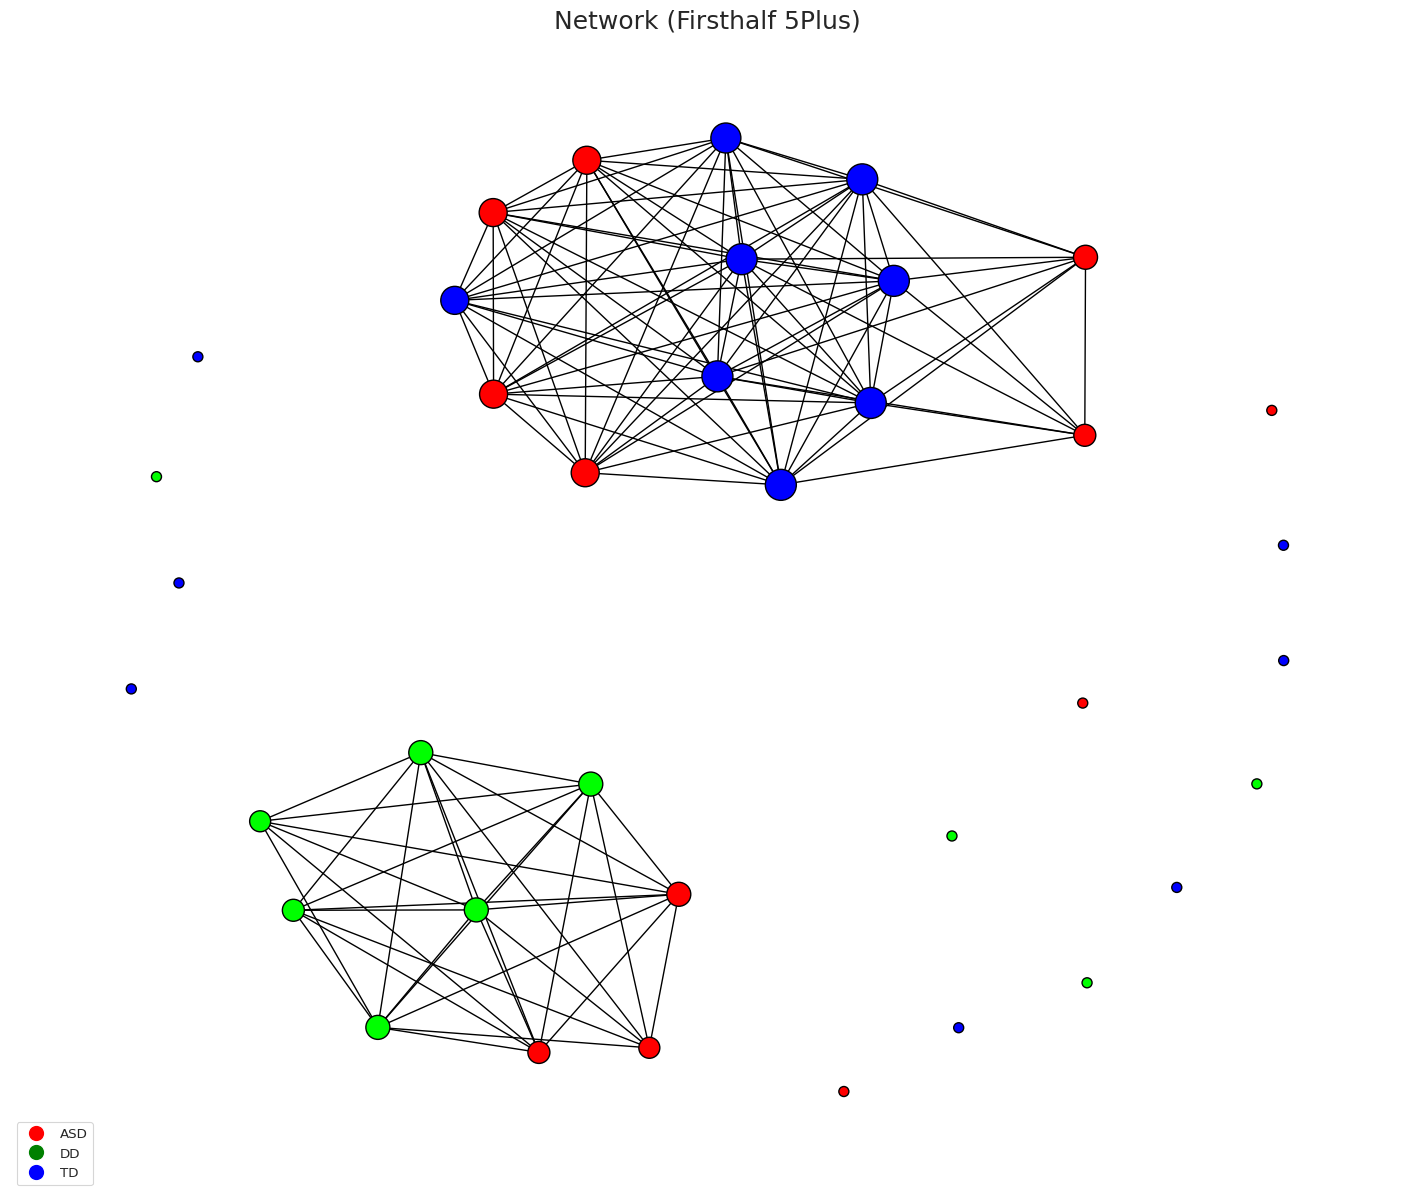

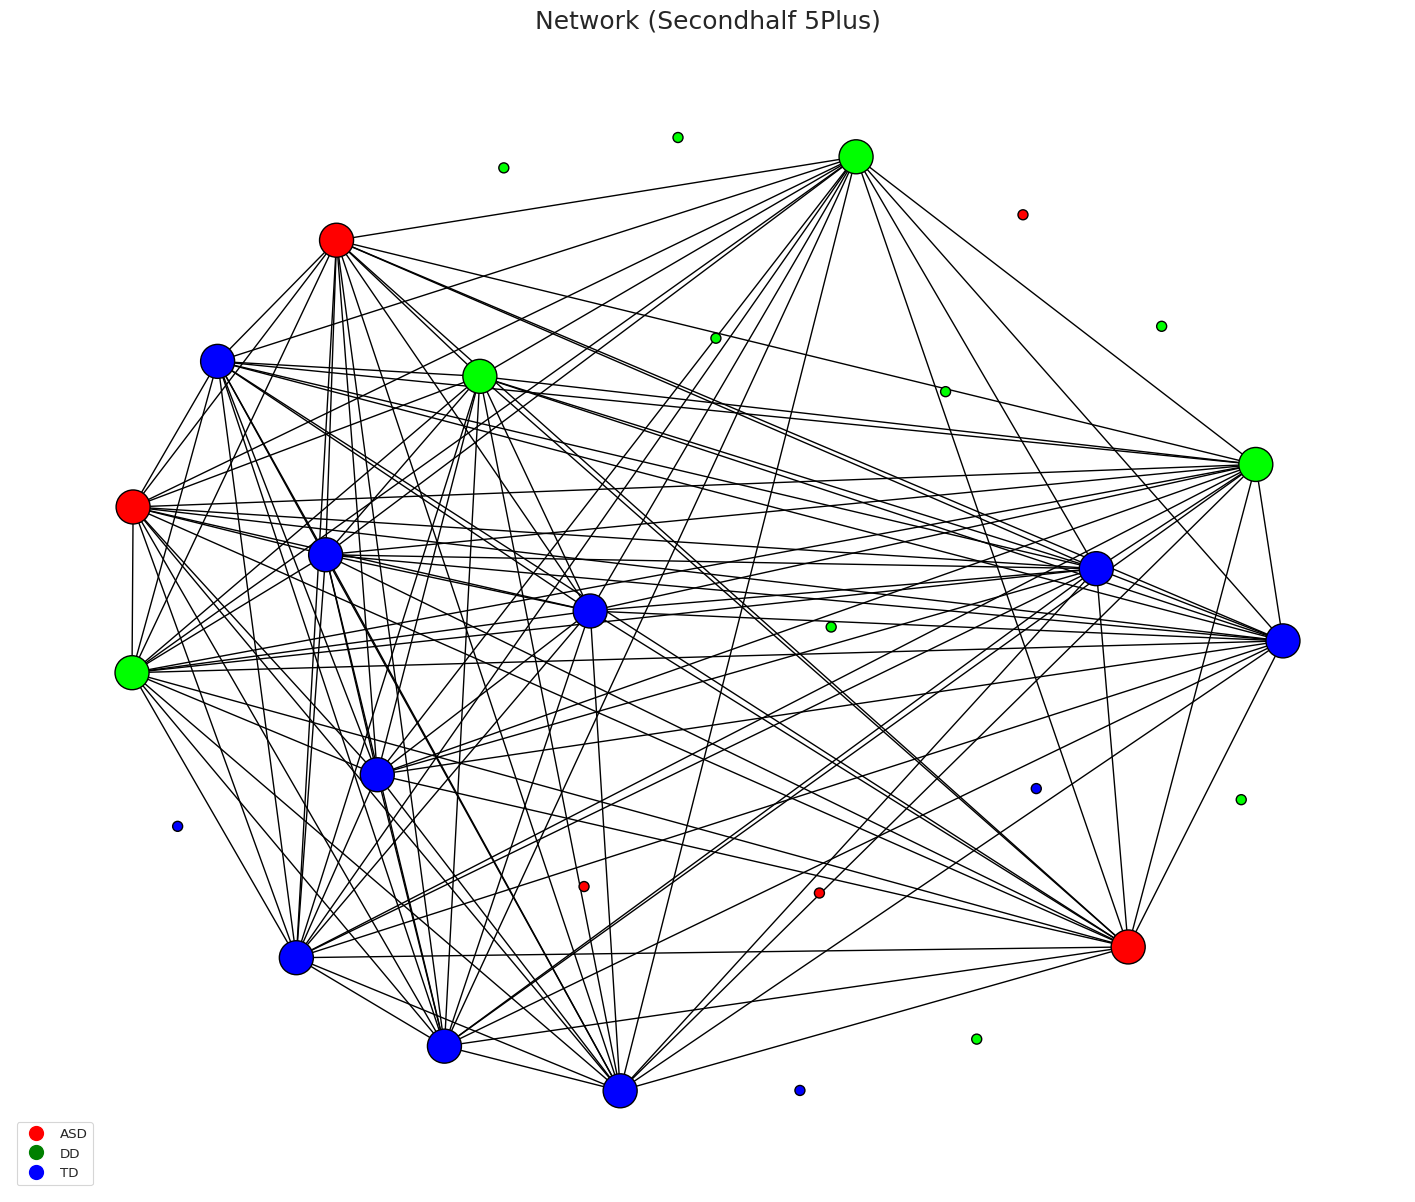

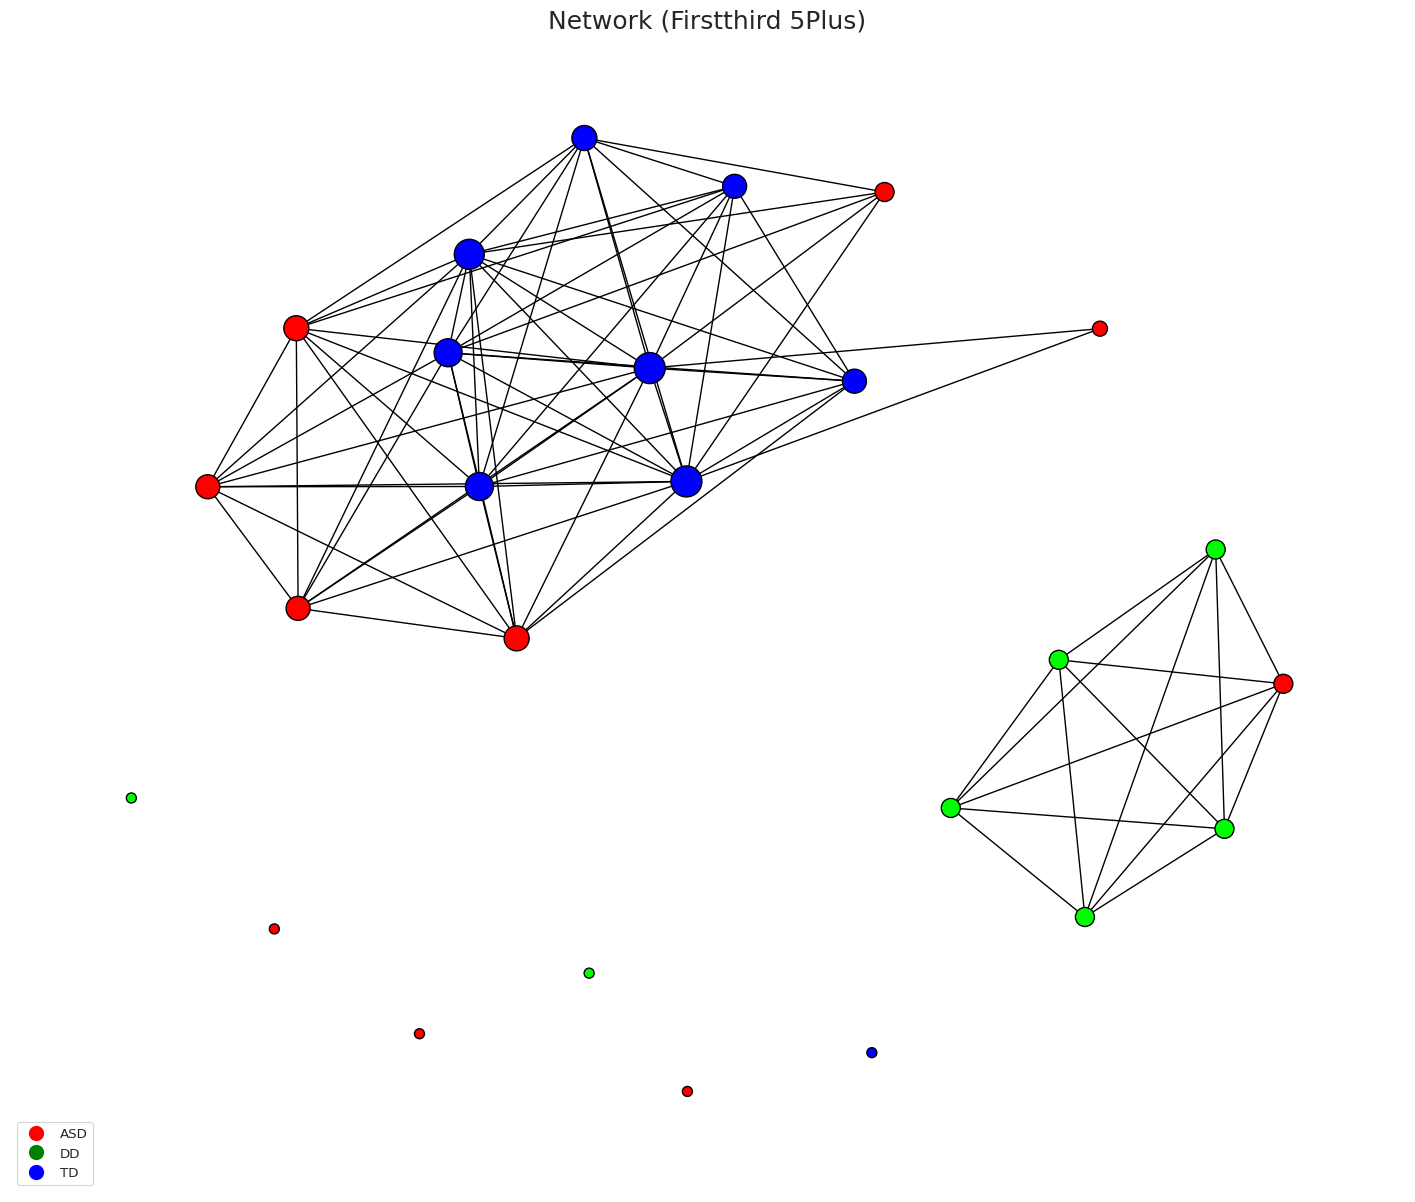

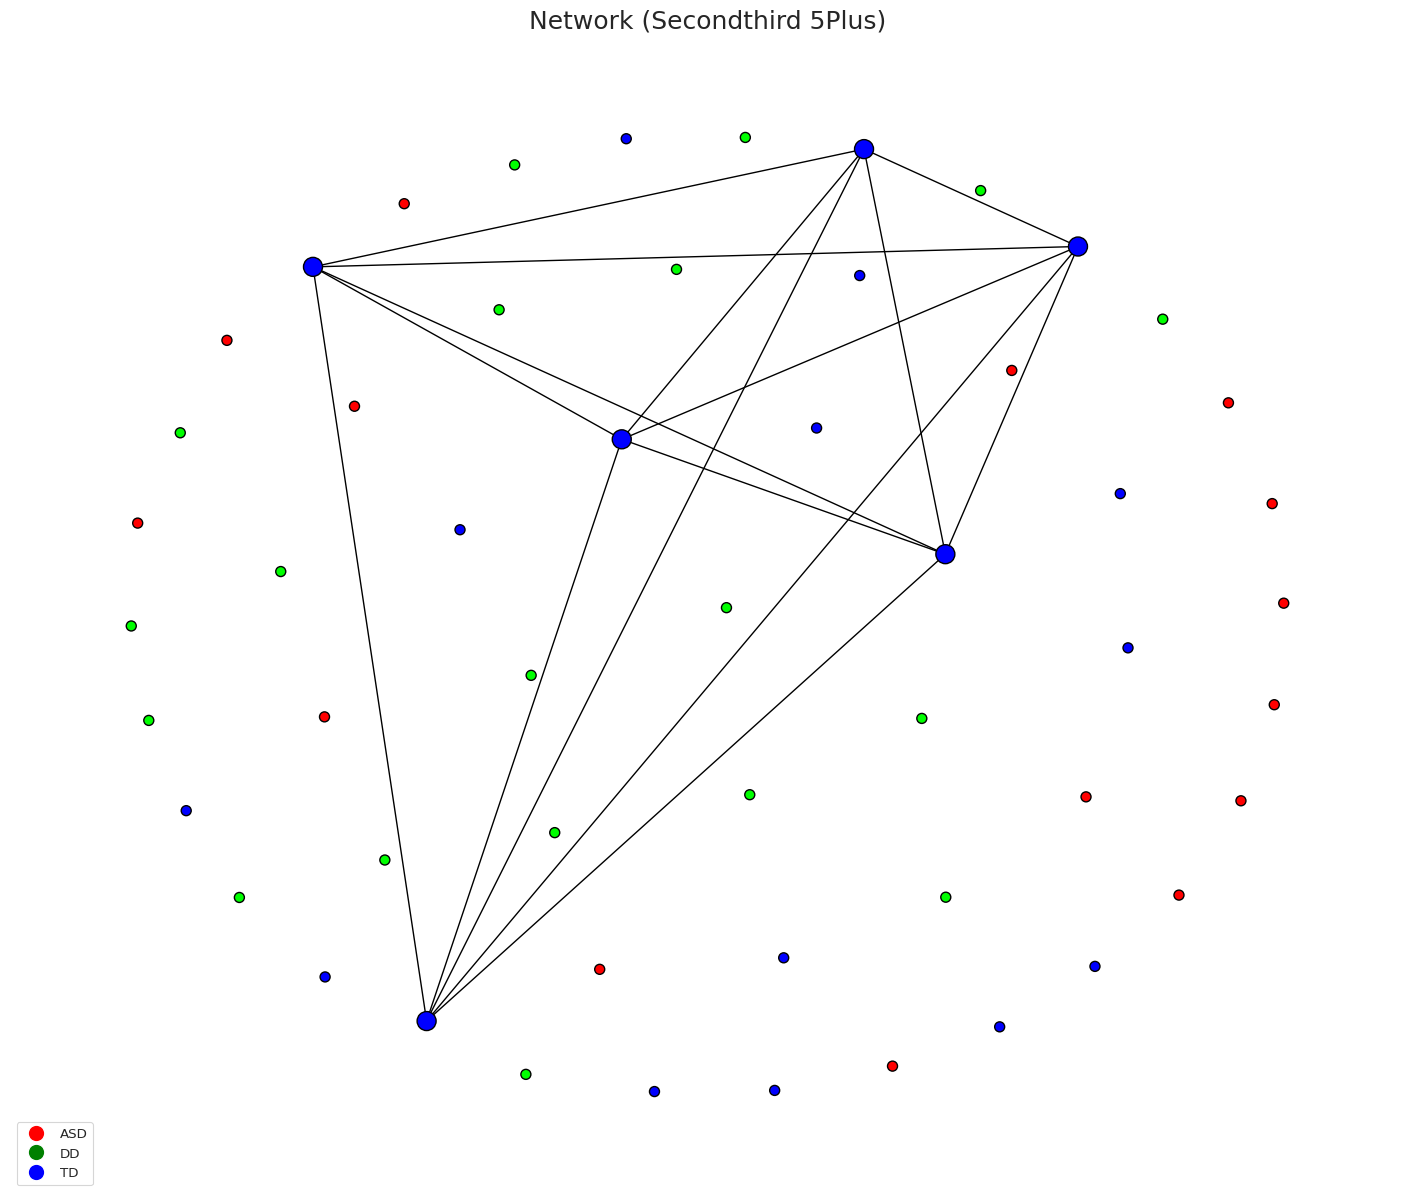

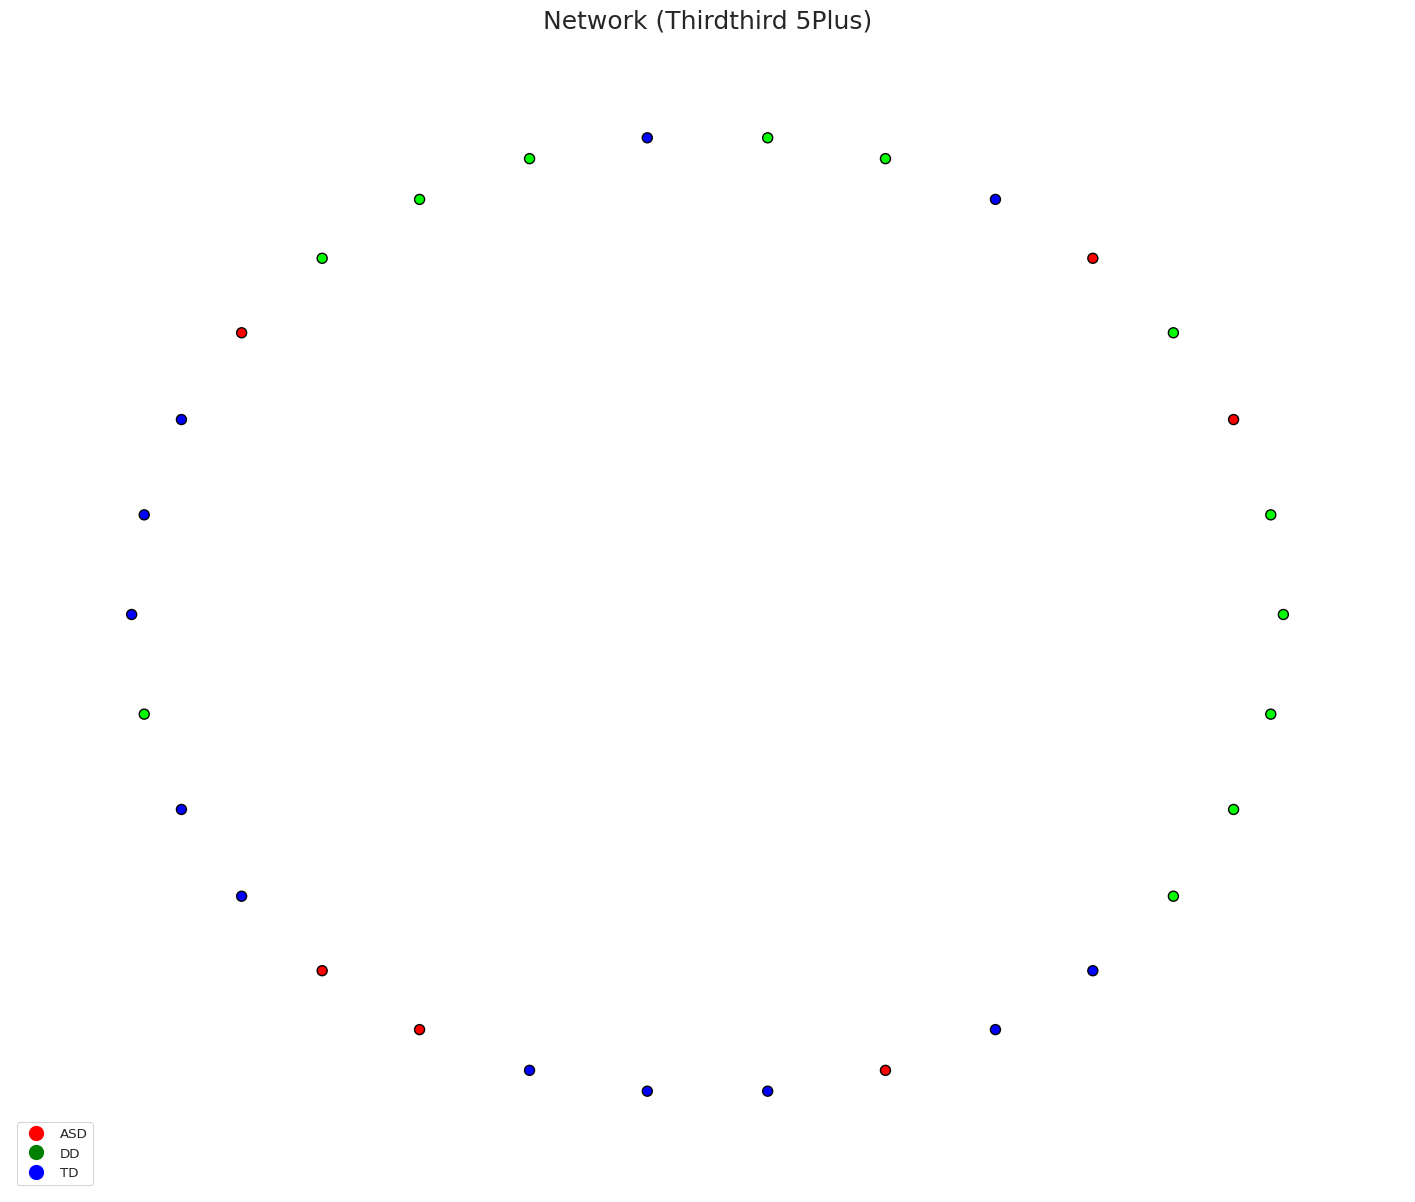

In [10]:
generate_network(df, threshold=5, label="full_5plus")
generate_network(first_half, threshold=5, label="firsthalf_5plus")
generate_network(second_half, threshold=5, label="secondhalf_5plus")
generate_network(first_third, threshold=5, label="firstthird_5plus")
generate_network(second_third, threshold=5, label="secondthird_5plus")
generate_network(third_third, threshold=5, label="thirdthird_5plus")


Generate Graphs — 3+ Interaction Threshold

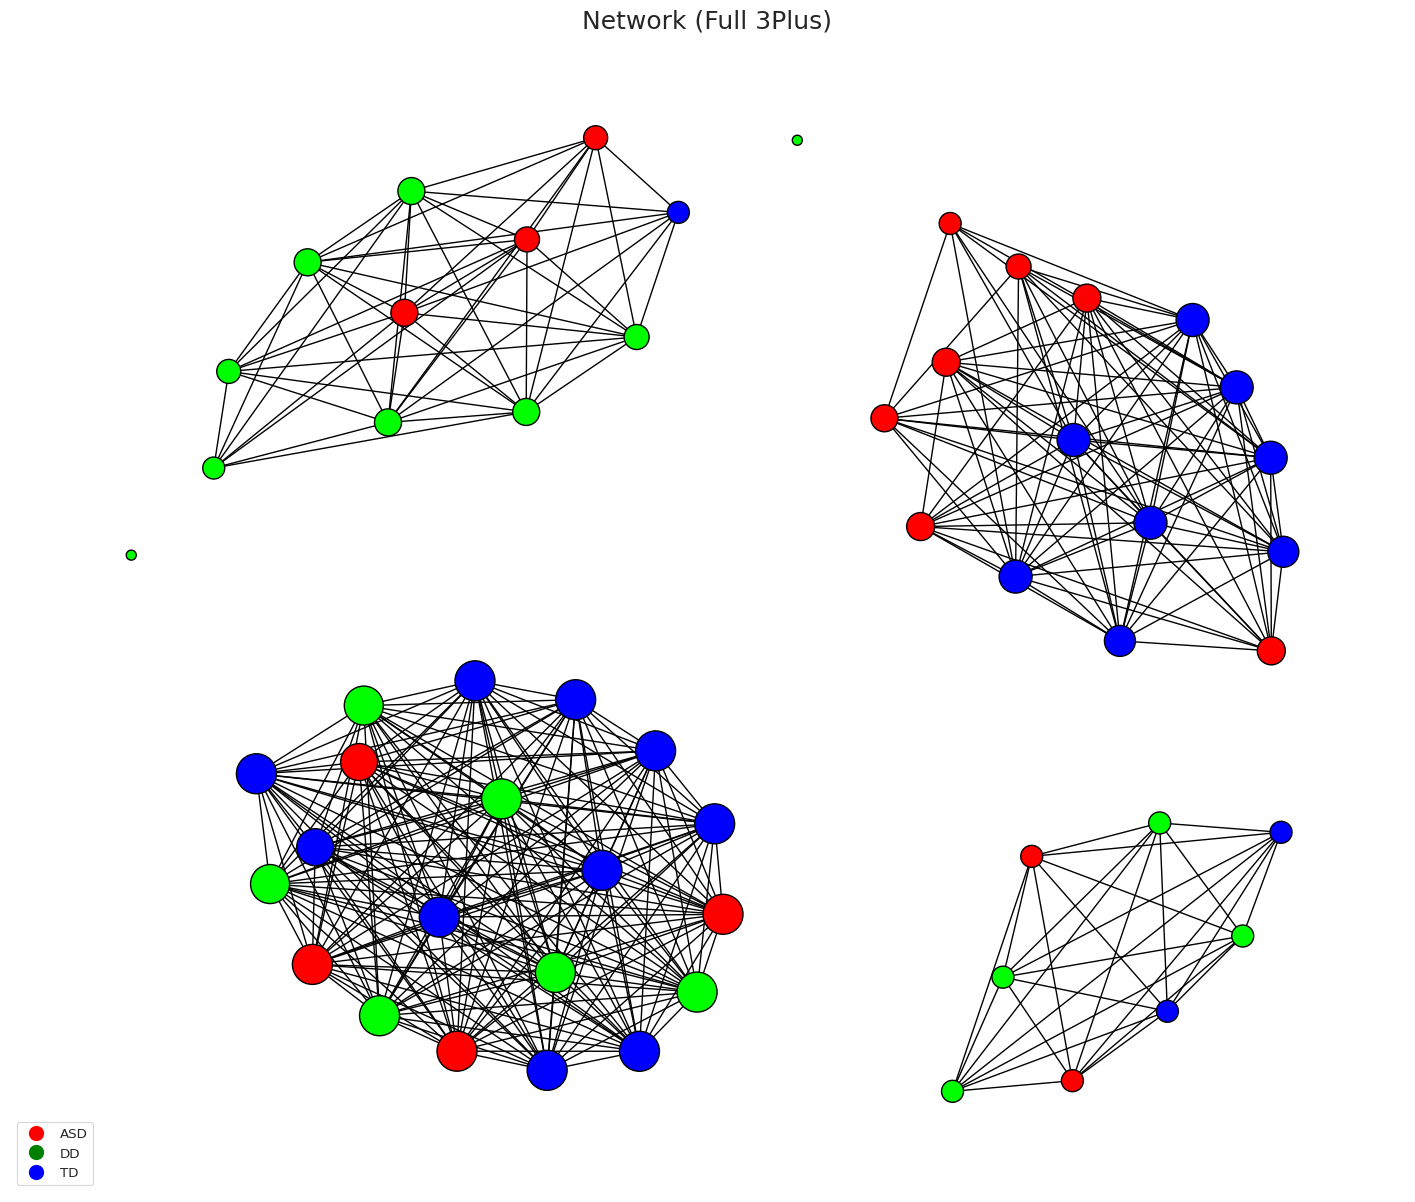

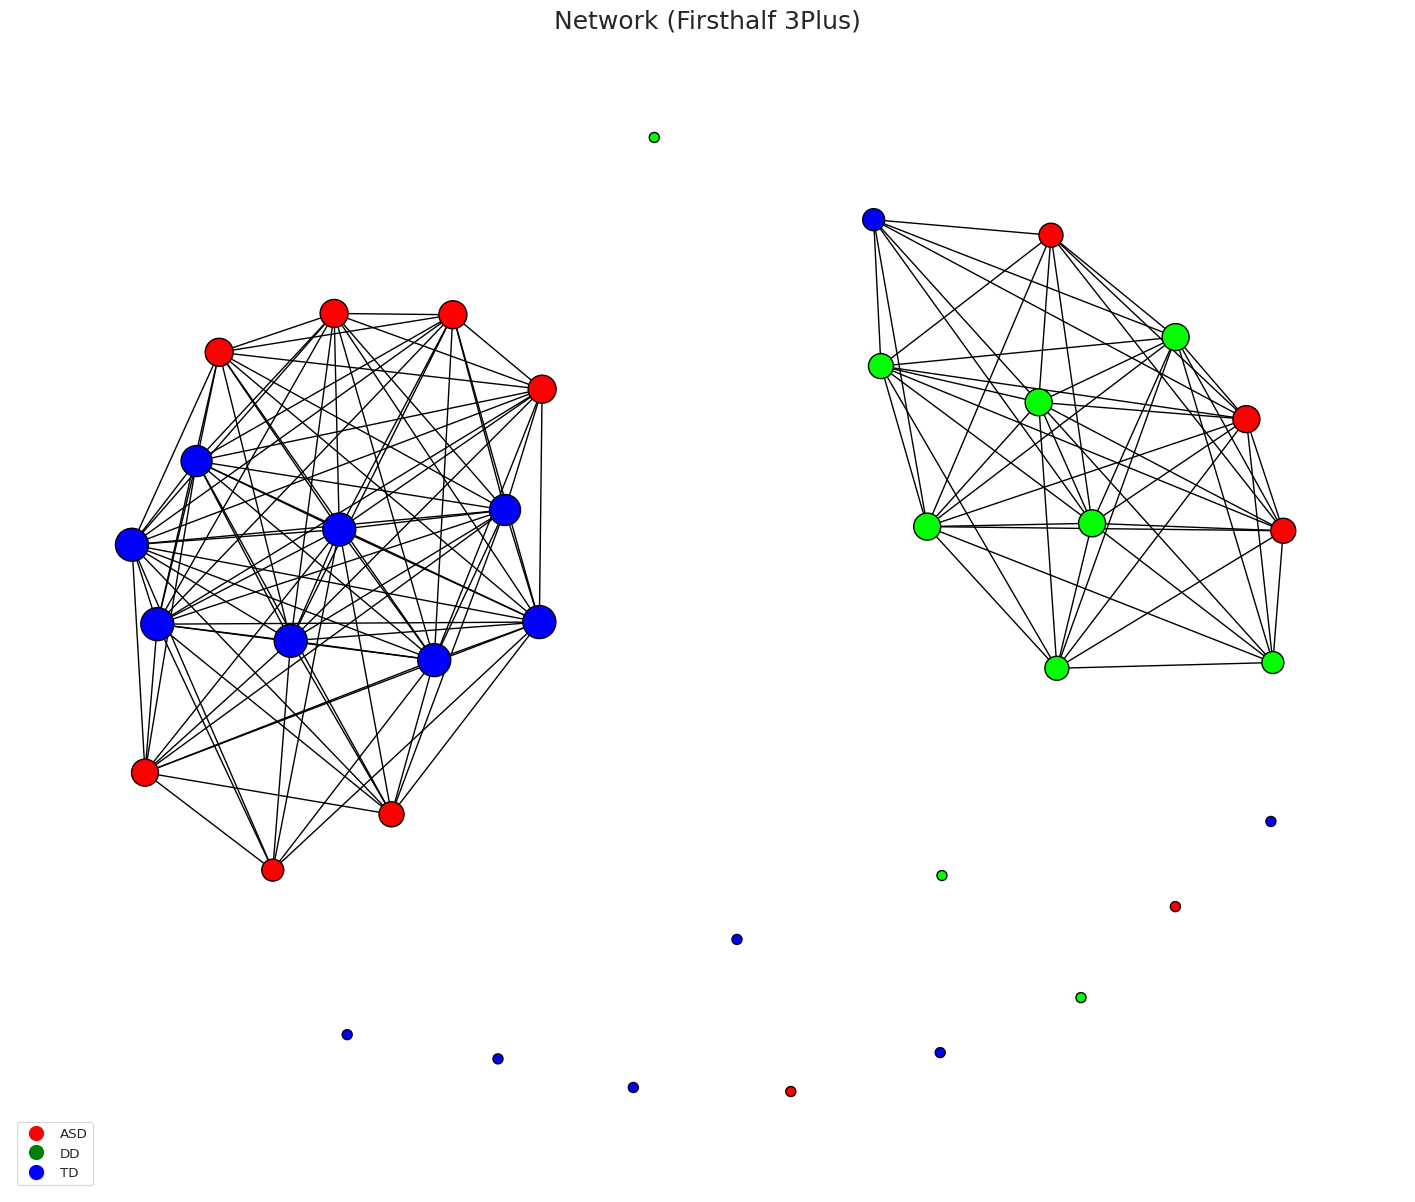

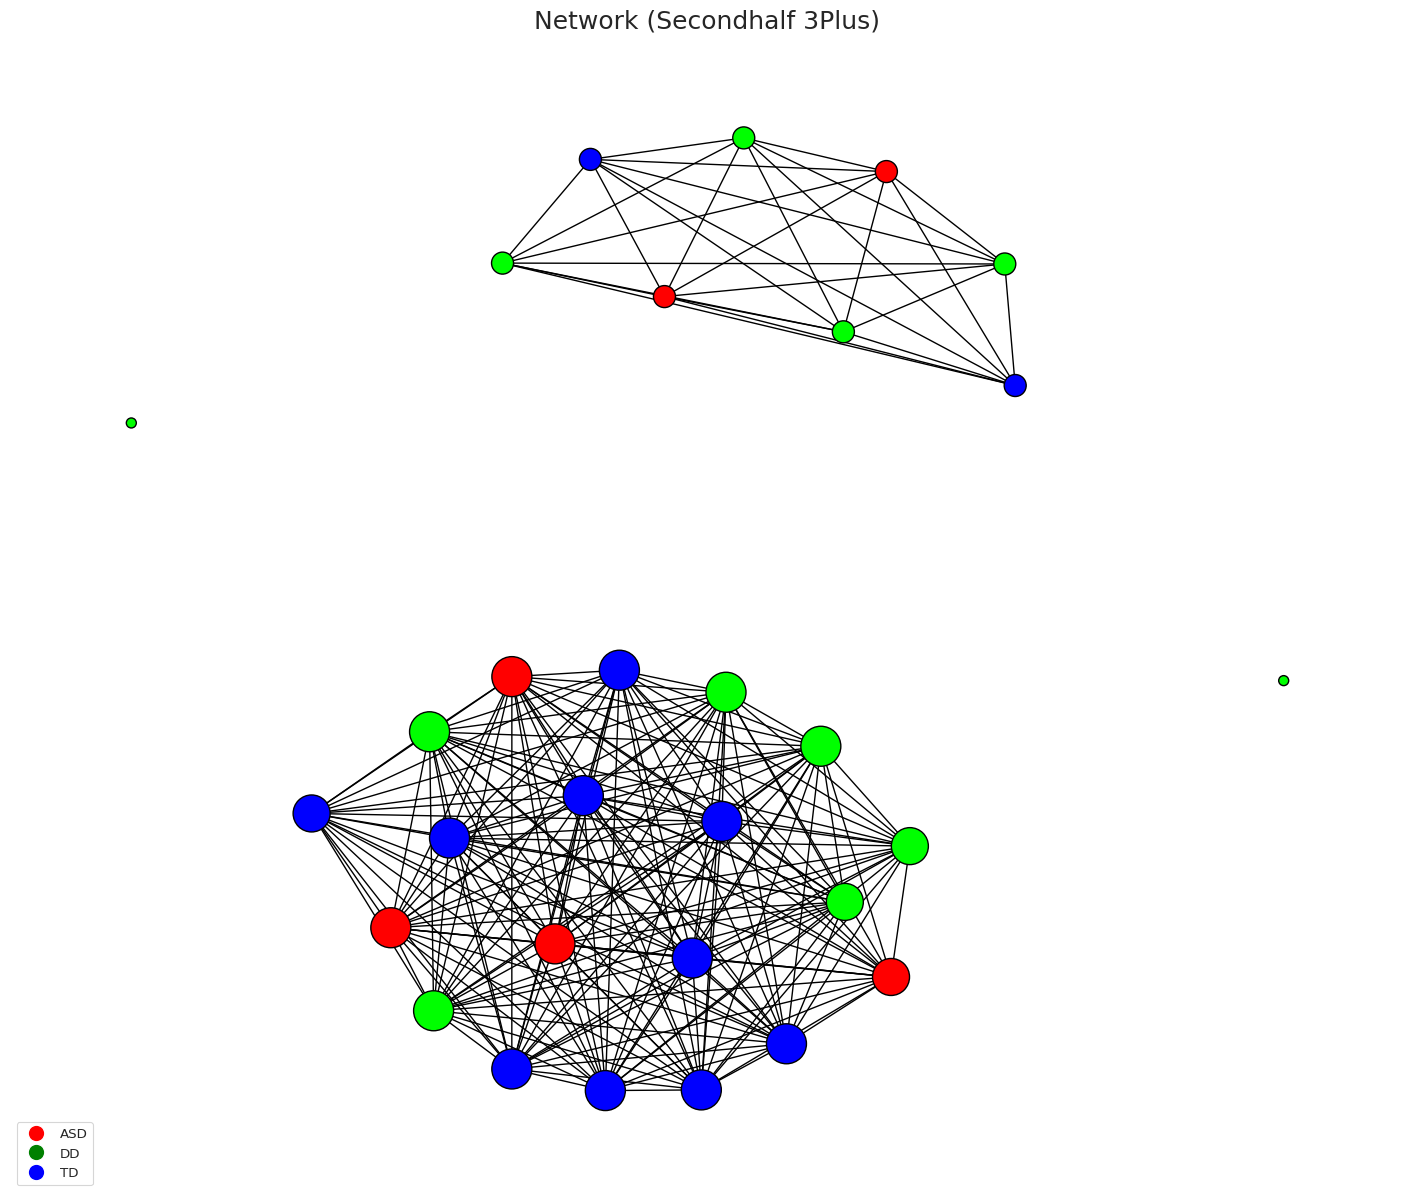

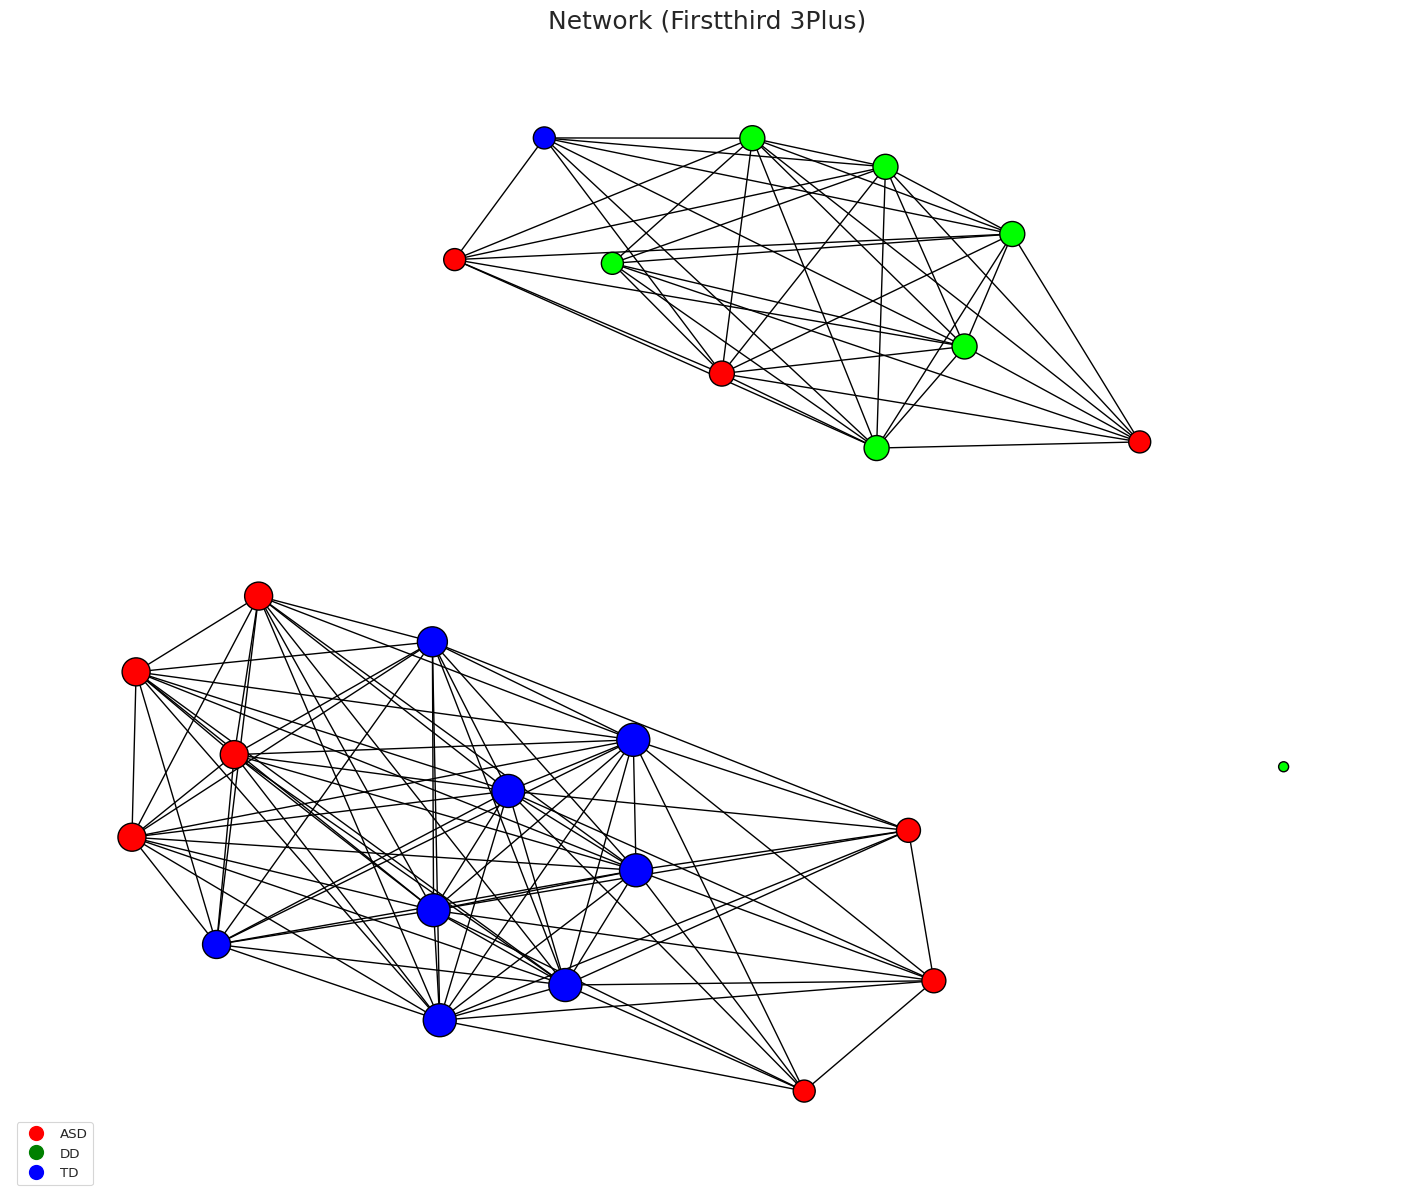

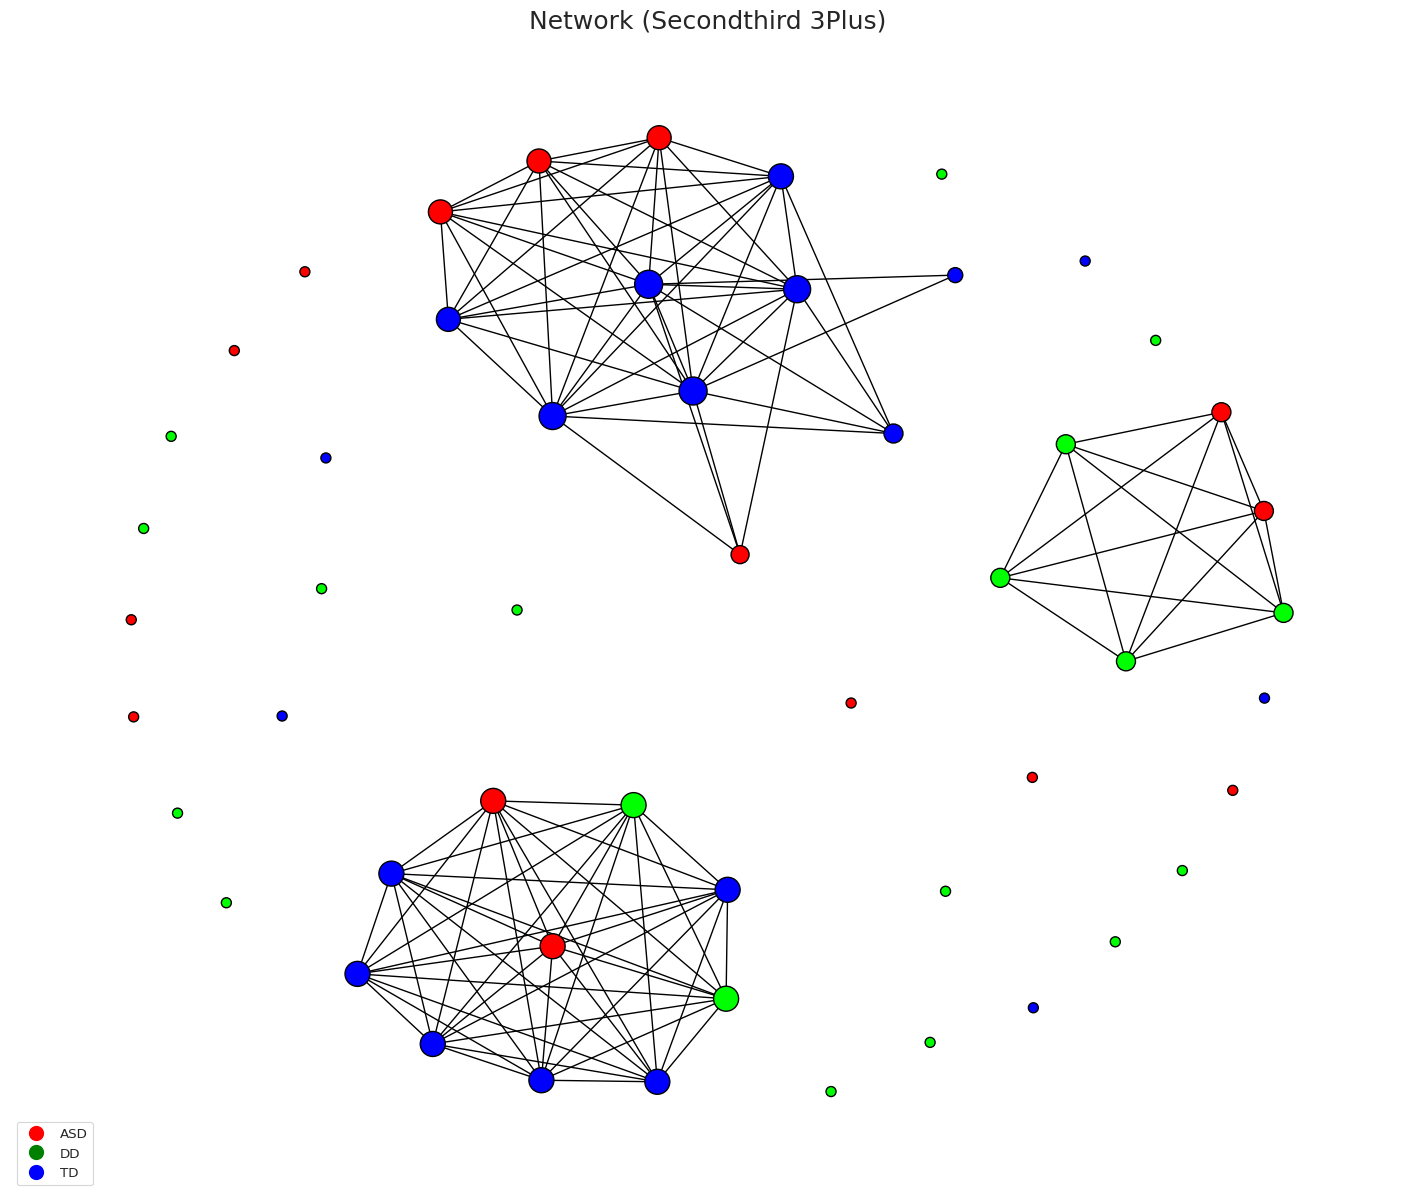

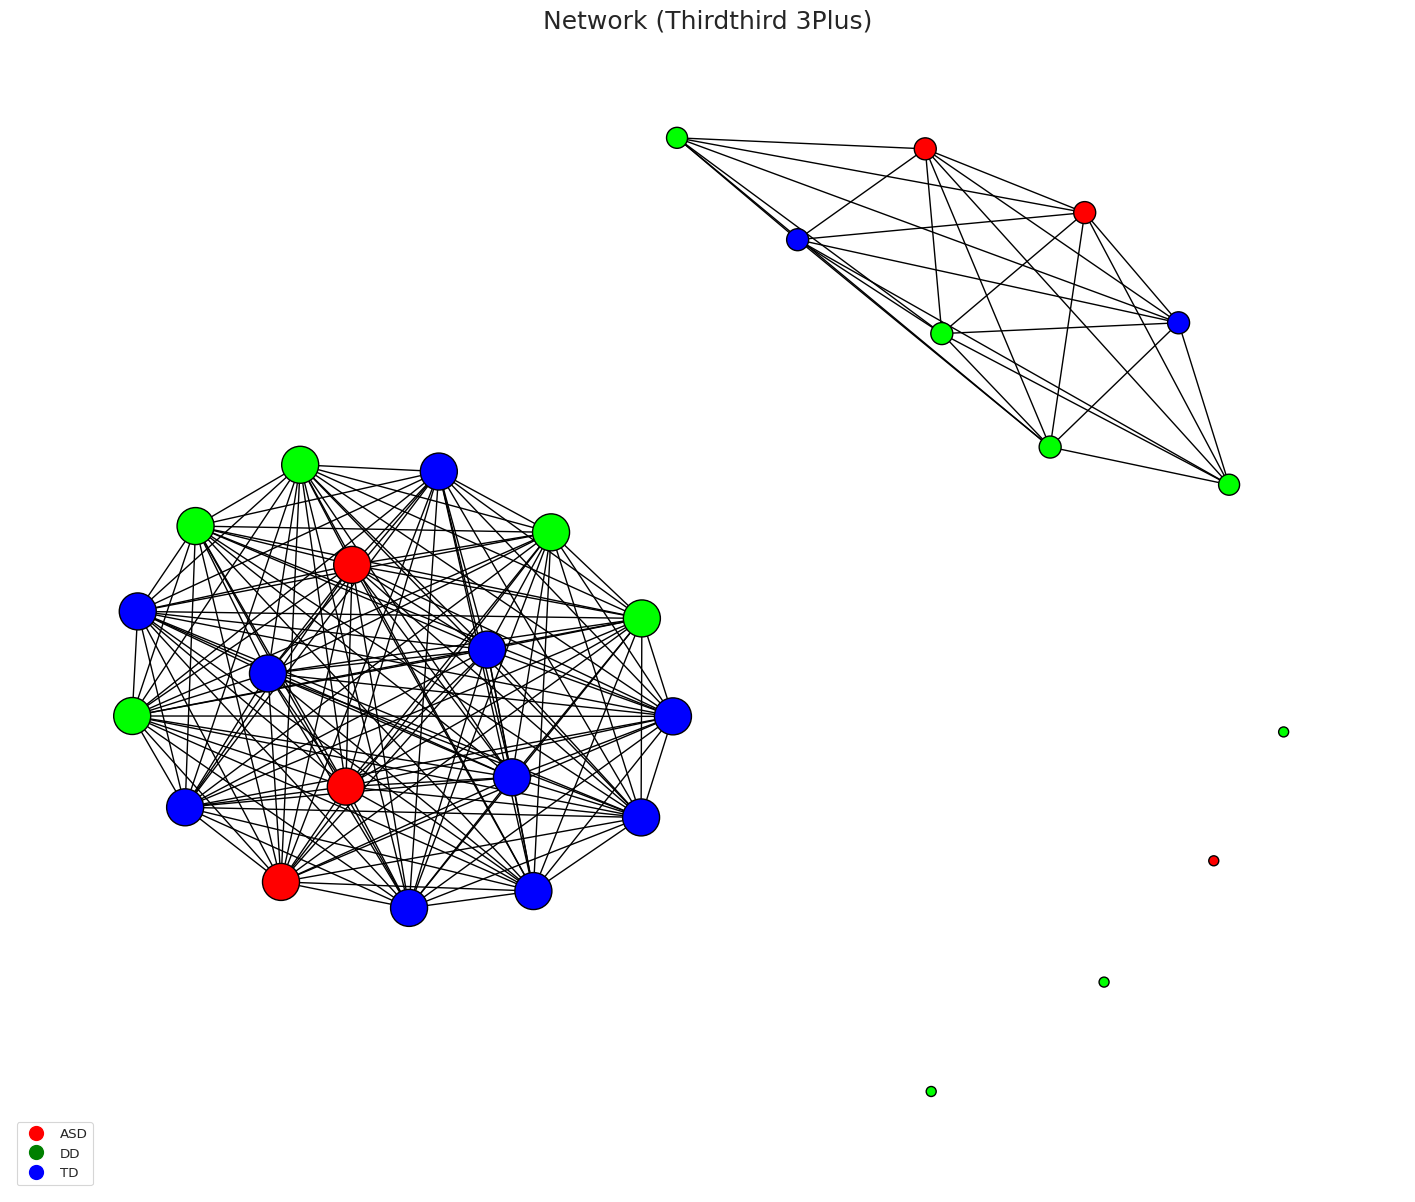

In [11]:
generate_network(df, threshold=3, label="full_3plus")
generate_network(first_half, threshold=3, label="firsthalf_3plus")
generate_network(second_half, threshold=3, label="secondhalf_3plus")
generate_network(first_third, threshold=3, label="firstthird_3plus")
generate_network(second_third, threshold=3, label="secondthird_3plus")
generate_network(third_third, threshold=3, label="thirdthird_3plus")



Generate Graphs - 10+ Interaction Threshold

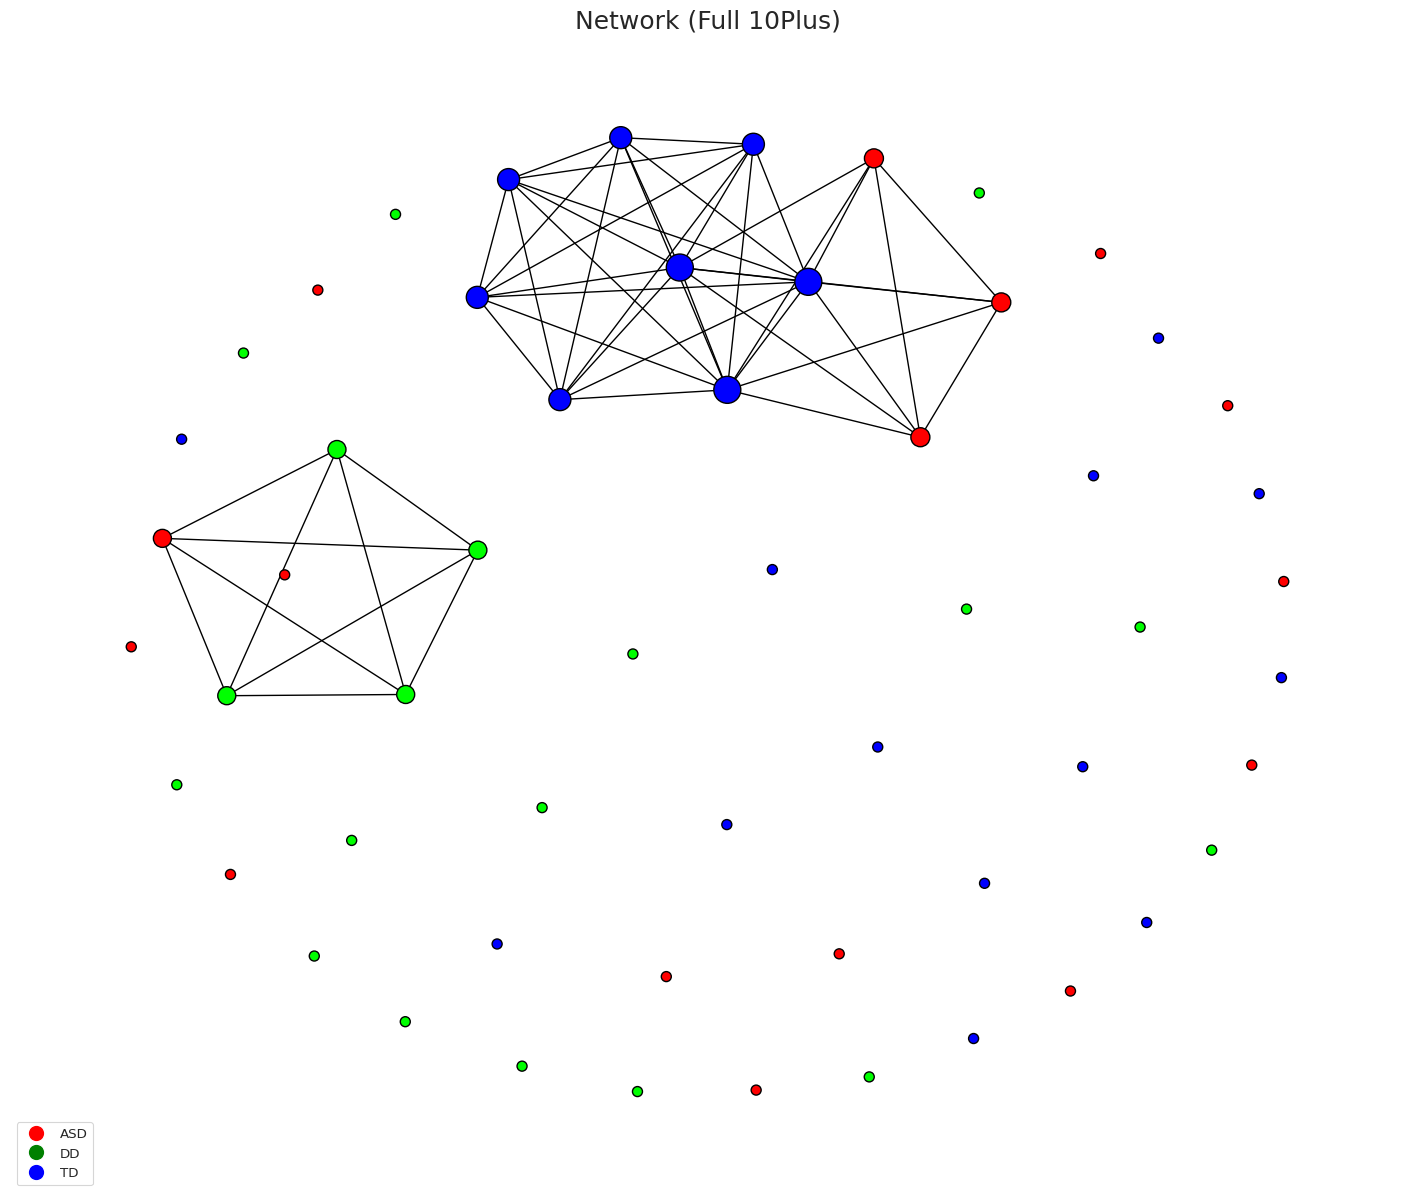

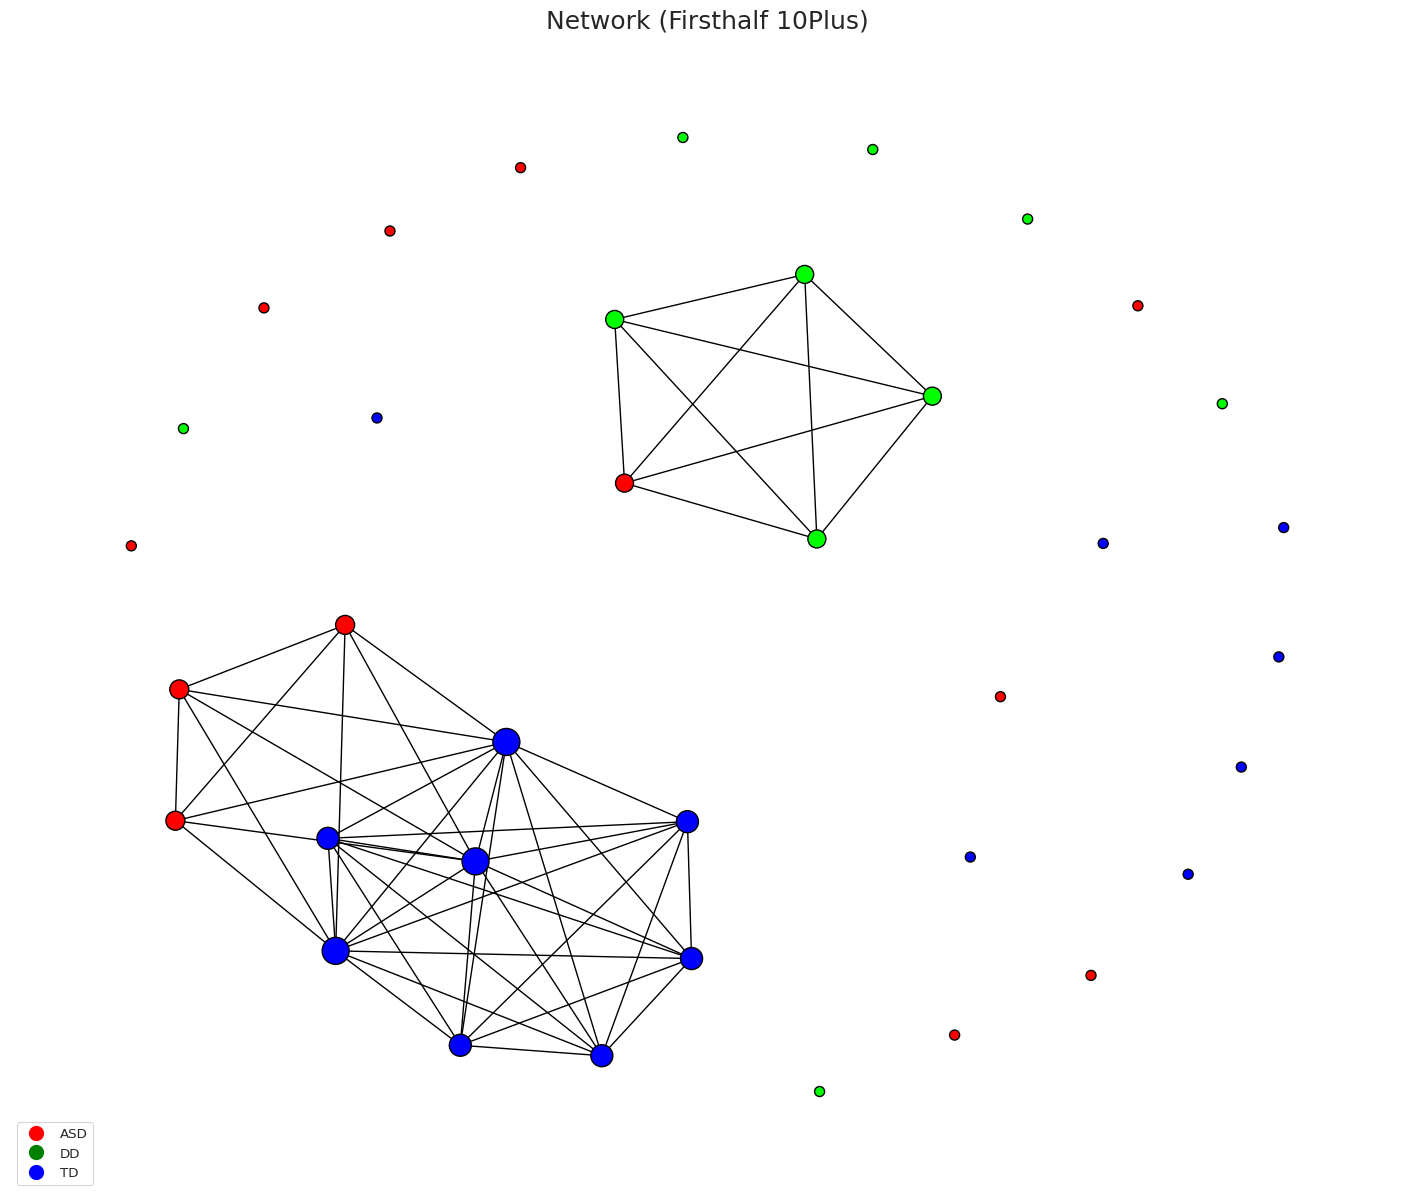

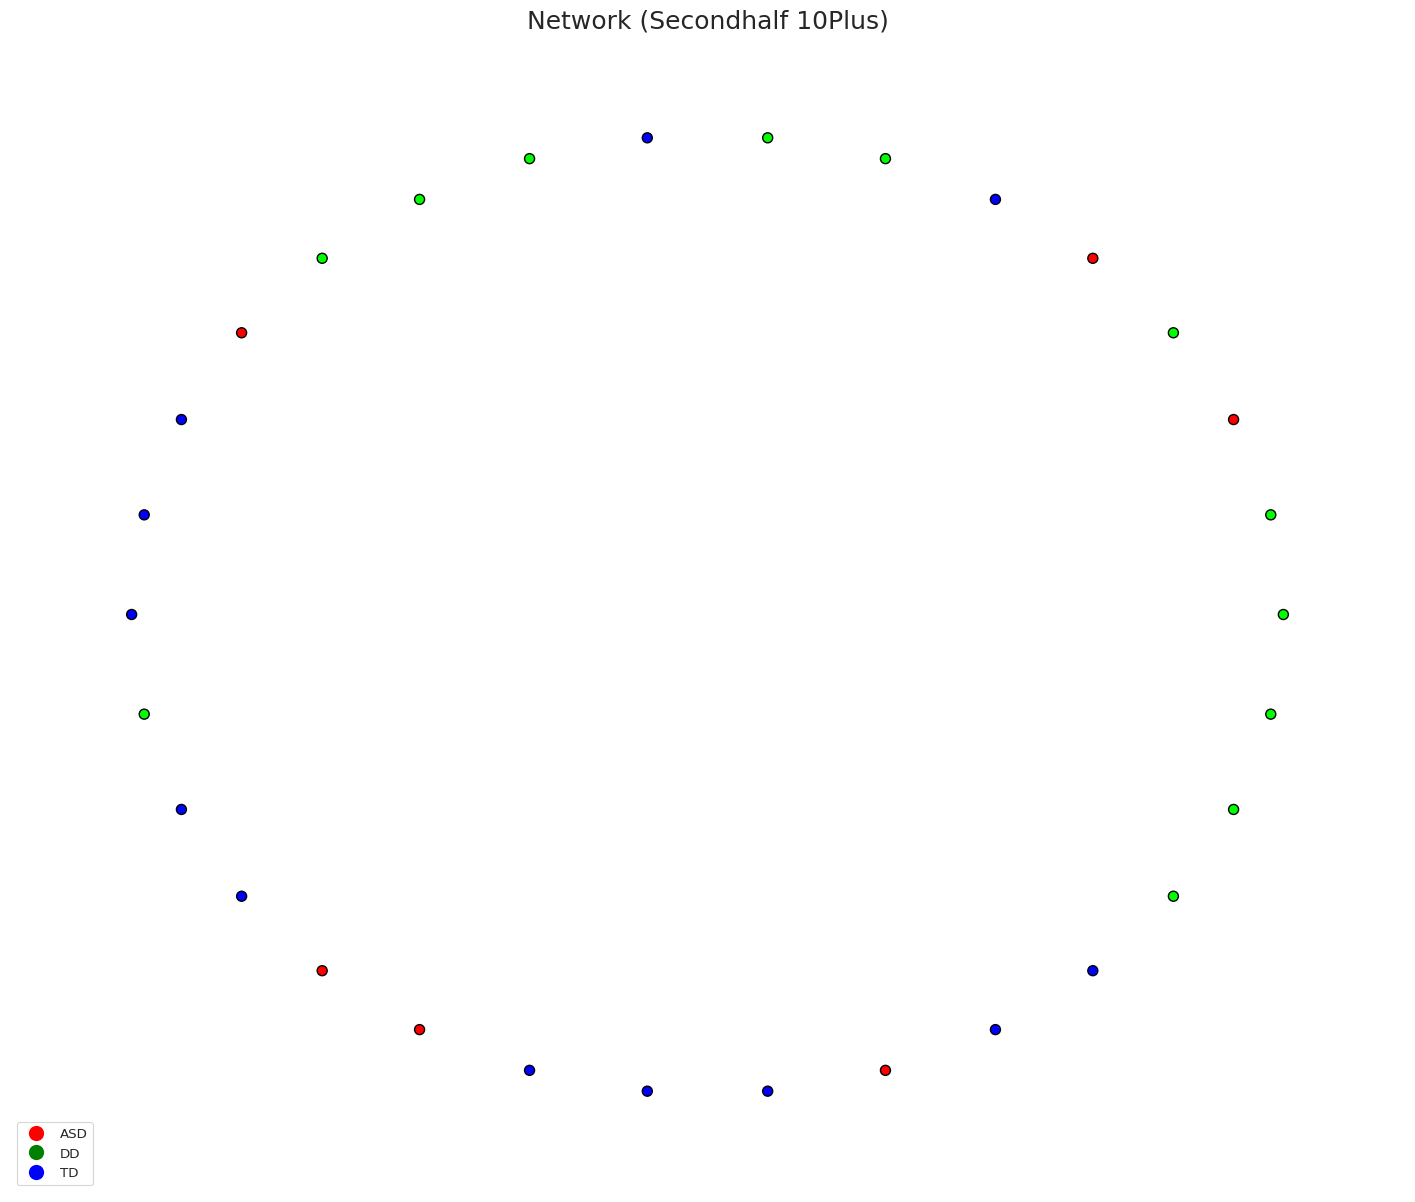

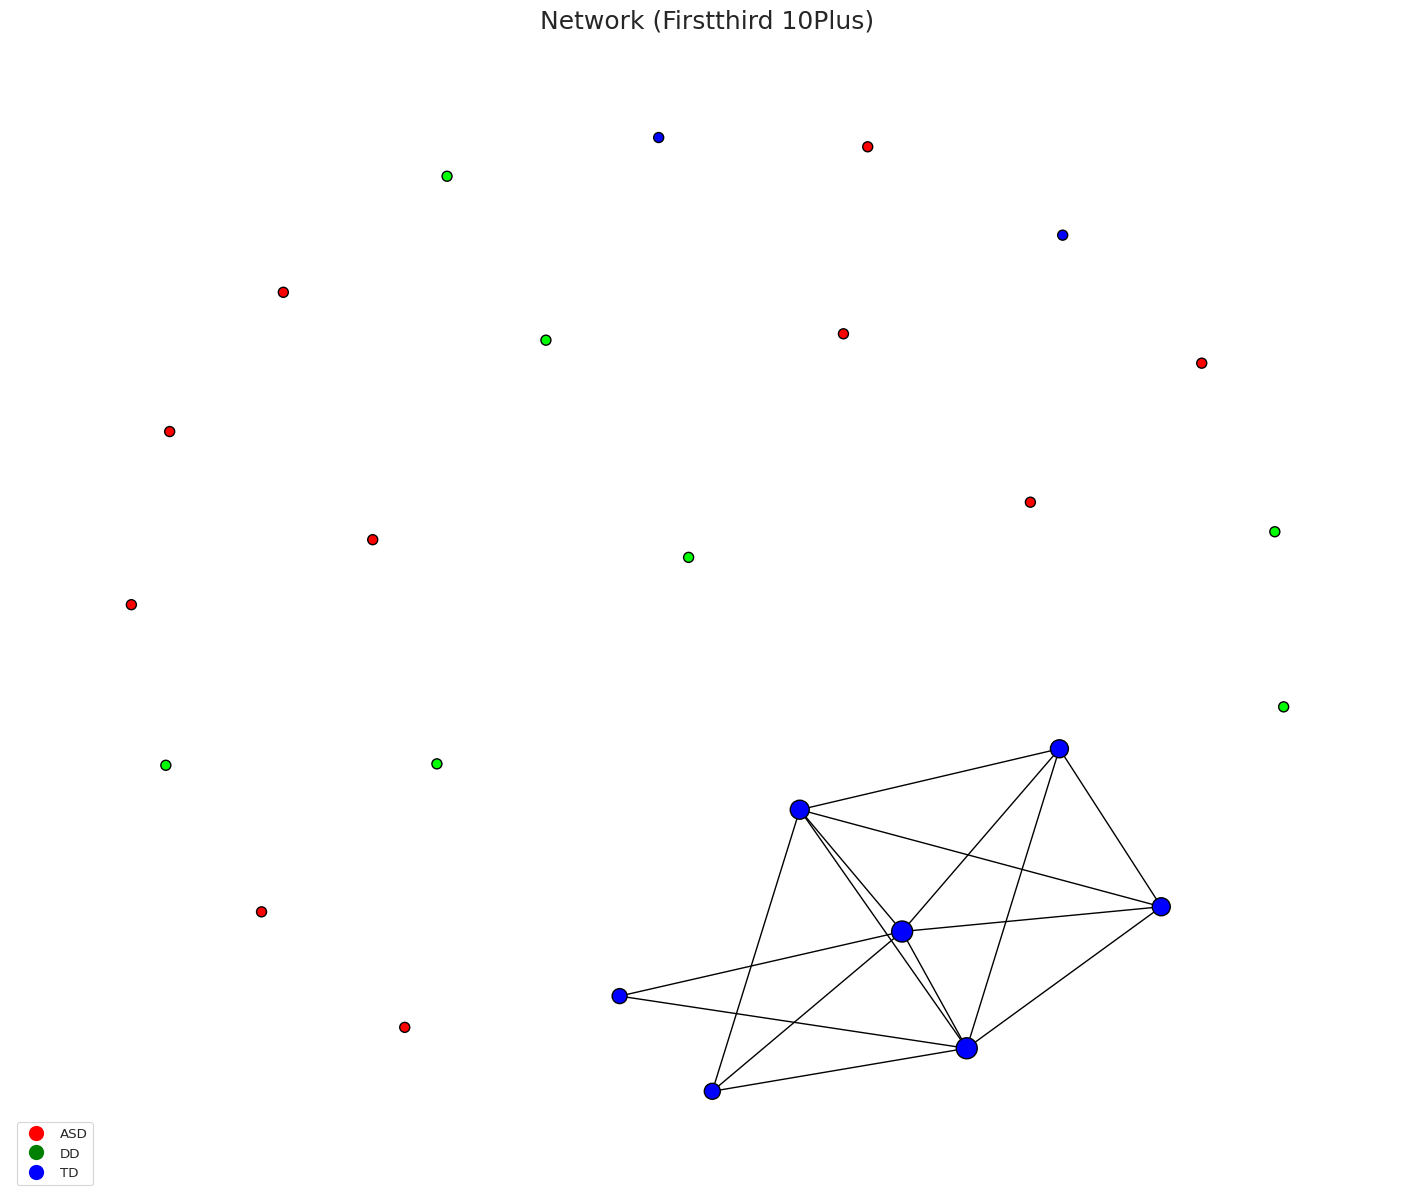

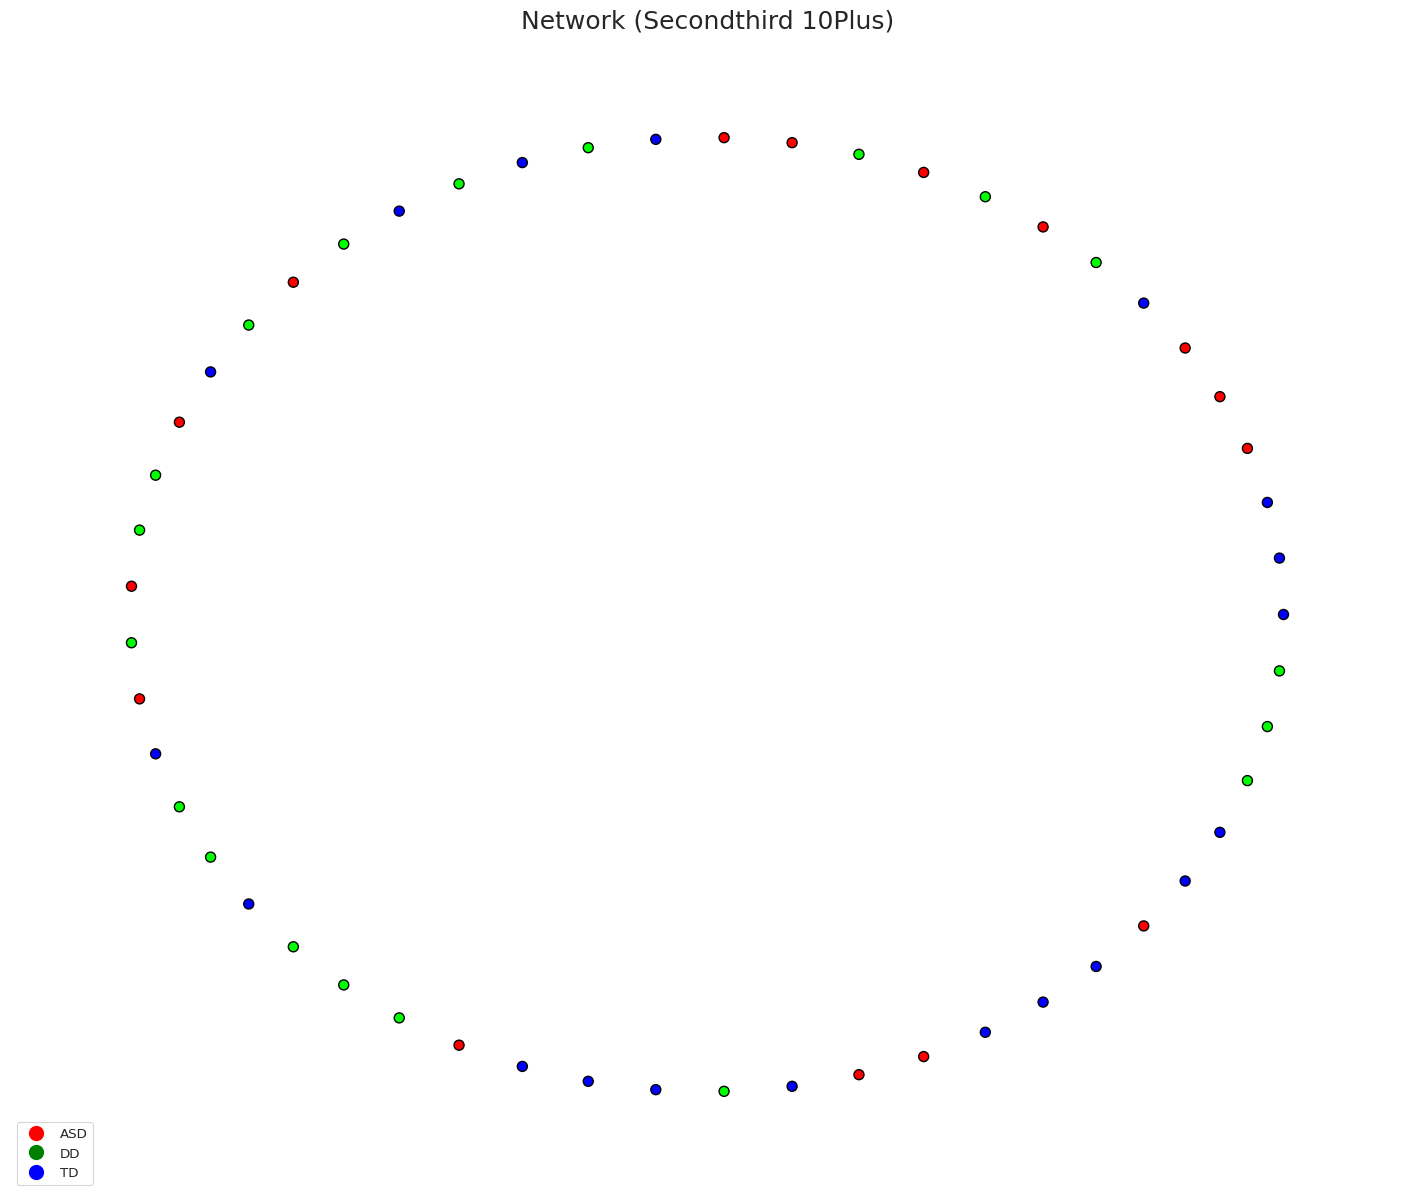

In [12]:
generate_network(df, threshold=10, label="full_10plus")
generate_network(first_half, threshold=10, label="firsthalf_10plus")
generate_network(second_half, threshold=10, label="secondhalf_10plus")
generate_network(first_third, threshold=10, label="firstthird_10plus")
generate_network(second_third, threshold=10, label="secondthird_10plus")

# Section 4: Hypothesis Testing & Simulation (Structural Externalities)

Install & Import Required Packages

In [71]:
# Install igraph and networkx (if needed)
!pip install python-igraph networkx --quiet

# Imports (if needed)
import pandas as pd
import numpy as np
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
from typing import Tuple
import random


Define Utility Functions

In [72]:
# Number of simulations to generate null distribution
SIMULATIONS = 1000

def load_adj_matrix(path: str) -> Tuple[ig.Graph, np.ndarray]:
    """Load CSV adjacency matrix and return igraph graph + numpy matrix."""
    adj = pd.read_csv(path, index_col=0)
    adj_matrix = adj.values.astype(int)
    g = ig.Graph.Adjacency((adj_matrix > 0).tolist(), mode=ig.ADJ_UNDIRECTED)
    g.vs["name"] = list(adj.index)
    return g, adj_matrix

def compute_statistics(g: ig.Graph) -> dict:
    """Compute observed graph-level statistics."""
    return {
        "transitivity": g.transitivity_undirected(),
        "clustering": np.mean(g.transitivity_local_undirected(mode="zero")),
        "assortativity": g.assortativity_degree(directed=False)
    }

def simulate_null_distribution(degrees: list, simulations: int = SIMULATIONS) -> list:
    """Generate simulated graphs with preserved degree sequences (configuration model)."""
    results = []
    for _ in range(simulations):
        G_nx = nx.configuration_model(degrees, seed=random.randint(0, 1_000_000))
        G_nx = nx.Graph(G_nx)  # remove multi-edges
        G_nx.remove_edges_from(nx.selfloop_edges(G_nx))  # remove loops
        G_ig = ig.Graph.Adjacency(nx.to_numpy_array(G_nx).astype(int).tolist(), mode=ig.ADJ_UNDIRECTED)
        results.append(compute_statistics(G_ig))
    return results

def evaluate_statistic(observed: float, null_dist: list, alpha: float = 0.05) -> Tuple[float, float, bool]:
    """Compare observed statistic against simulated null distribution."""
    critical = np.quantile(null_dist, 1 - alpha)
    p_val = np.mean([x >= observed for x in null_dist])
    reject = observed > critical
    return p_val, critical, reject


Run the Structural Externality Test

In [73]:
def run_structural_tests(adjacency_csv_path: str, label: str) -> pd.DataFrame:
    print(f"Running tests for: {label}")

    g, adj_matrix = load_adj_matrix(adjacency_csv_path)
    observed = compute_statistics(g)
    degrees = g.degree()
    print("Observed statistics computed")

    sim_stats = simulate_null_distribution(degrees)
    print("Simulations completed")

    nulls = {
        "transitivity": [s["transitivity"] for s in sim_stats],
        "clustering": [s["clustering"] for s in sim_stats],
        "assortativity": [s["assortativity"] for s in sim_stats]
    }

    results = {}
    for stat_name in ["transitivity", "clustering", "assortativity"]:
        p_val, critical, reject = evaluate_statistic(observed[stat_name], nulls[stat_name])
        results[stat_name.capitalize()] = {
            "Observed": observed[stat_name],
            "Critical (95%)": critical,
            "p-value": p_val,
            "Reject H0": reject
        }

    return pd.DataFrame(results).T


Run Tests on Selected Networks

In [74]:
# 5+ Interaction Networks
display(run_structural_tests("adjacency_matrix_full_5plus.csv", "Full 5+"))
display(run_structural_tests("adjacency_matrix_firsthalf_5plus.csv", "First Half 5+"))
display(run_structural_tests("adjacency_matrix_secondhalf_5plus.csv", "Second Half 5+"))
display(run_structural_tests("adjacency_matrix_firstthird_5plus.csv", "First Third 5+"))
display(run_structural_tests("adjacency_matrix_secondthird_5plus.csv", "Second Third 5+"))
display(run_structural_tests("adjacency_matrix_thirdthird_5plus.csv", "Third Third 5+"))

# 3+ Interaction Networks
display(run_structural_tests("adjacency_matrix_full_3plus.csv", "Full 3+"))
display(run_structural_tests("adjacency_matrix_firsthalf_3plus.csv", "First Half 3+"))
display(run_structural_tests("adjacency_matrix_secondhalf_3plus.csv", "Second Half 3+"))
display(run_structural_tests("adjacency_matrix_firstthird_3plus.csv", "First Third 3+"))
display(run_structural_tests("adjacency_matrix_secondthird_3plus.csv", "Second Third 3+"))
display(run_structural_tests("adjacency_matrix_thirdthird_3plus.csv", "Third Third 3+"))

# 10+ Interaction Threshold
display(run_structural_tests("adjacency_matrix_full_10plus.csv", "Full 10+"))
display(run_structural_tests("adjacency_matrix_firsthalf_10plus.csv", "First Half 10+"))
display(run_structural_tests("adjacency_matrix_secondhalf_10plus.csv", "Second Half 10+"))
display(run_structural_tests("adjacency_matrix_firstthird_10plus.csv", "First Third 10+"))
display(run_structural_tests("adjacency_matrix_secondthird_10plus.csv", "Second Third 10+"))
display(run_structural_tests("adjacency_matrix_thirdthird_10plus.csv", "Third Third 10+"))



Running tests for: Full 5+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity   0.927765       0.285594     0.0      True
Clustering      0.68605       0.213702     0.0      True
Assortativity  0.664331       0.045639     0.0      True

Running tests for: First Half 5+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity   0.916822       0.380545     0.0      True
Clustering     0.578687       0.239917     0.0      True
Assortativity  0.573886       0.052407     0.0      True

Running tests for: Second Half 5+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity        1.0       0.657384     0.0      True
Clustering     0.533333       0.352313     0.0      True
Assortativity       NaN       0.019634     0.0     False

Running tests for: First Third 5+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity   0.808989       0.386873     0.0      True
Clustering     0.689592        0.32433     0.0      True
Assortativity  0.248833       0.052749     0.0      True

Running tests for: Second Third 5+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity        1.0           0.75     0.0      True
Clustering     0.113208       0.093082     0.0      True
Assortativity       NaN            NaN     0.0     False

Running tests for: Third Third 5+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity       NaN            NaN     0.0     False
Clustering         0.0            0.0     1.0     False
Assortativity      NaN            NaN     0.0     False

Running tests for: Full 3+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity   0.959804        0.25182     0.0      True
Clustering     0.920369       0.246312     0.0      True
Assortativity  0.918236        0.03859     0.0      True

Running tests for: First Half 3+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity   0.896406       0.360029     0.0      True
Clustering     0.644174       0.257342     0.0      True
Assortativity  0.322147       0.053239     0.0      True

Running tests for: Second Half 3+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity   0.981439       0.481392     0.0      True
Clustering     0.920858       0.461854     0.0      True
Assortativity  0.962412       0.023718     0.0      True

Running tests for: First Third 3+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity   0.890032       0.361894     0.0      True
Clustering      0.88459       0.355924     0.0      True
Assortativity  0.324228         0.0478     0.0      True

Running tests for: Second Third 3+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity   0.921019        0.27609     0.0      True
Clustering     0.504784       0.155085     0.0      True
Assortativity  0.263476        0.09567     0.0      True

Running tests for: Third Third 3+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity   0.997696       0.471548     0.0      True
Clustering     0.857143        0.42009     0.0      True
Assortativity  0.997503       0.035021     0.0      True

Running tests for: Full 10+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity       0.85       0.379542     0.0      True
Clustering     0.267857       0.117775     0.0      True
Assortativity  0.294118       0.073489     0.0      True

Running tests for: First Half 10+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity       0.85       0.387145     0.0      True
Clustering     0.405405       0.183343     0.0      True
Assortativity  0.294118       0.065249     0.0      True

Running tests for: Second Half 10+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity       NaN            NaN     0.0     False
Clustering         0.0            0.0     1.0     False
Assortativity      NaN            NaN     0.0     False

Running tests for: First Third 10+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity       0.75        0.62069   0.001      True
Clustering     0.230769       0.194872   0.001      True
Assortativity -0.545961       0.043478   0.921     False

Running tests for: Second Third 10+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity       NaN            NaN     0.0     False
Clustering         0.0            0.0     1.0     False
Assortativity      NaN            NaN     0.0     False

Running tests for: Third Third 10+
Observed statistics computed
Simulations completed


Observed Critical (95%) p-value Reject H0
Transitivity       NaN            NaN     0.0     False
Clustering         0.0            0.0     1.0     False
Assortativity      NaN            NaN     0.0     False

# Section 5: Null Distribution Graphs

Install & Import Packages

In [46]:
# Install igraph (if needed)
!pip install python-igraph --quiet

import pandas as pd
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import random
from tqdm import tqdm



Build Network From Thresholded Interactions

In [47]:
def build_network_from_adjacency(path):
    adj = pd.read_csv(path, index_col=0)
    adj_matrix = adj.values.astype(int)
    g = ig.Graph.Adjacency((adj_matrix > 0).tolist(), mode=ig.ADJ_UNDIRECTED)
    g.vs["name"] = list(adj.index)
    return g


Simulate Null Distribution

In [48]:
def simulate_null_distribution(g, stat_func, n_simulations=1000):
    deg_seq = g.degree()
    null_stats = []
    for _ in tqdm(range(n_simulations)):
        try:
            g_sim = ig.Graph.Degree_Sequence(deg_seq, method="simple")
            null_stats.append(stat_func(g_sim))
        except:
            continue
    return np.array(null_stats)


Plot Null Distribution

In [49]:
def plot_null(null_stats, observed, title, filename):
    plt.figure(figsize=(8, 5))
    plt.hist(null_stats, bins=30, alpha=0.7, label='Null Distribution')
    plt.axvline(observed, color='red', linestyle='dashed', linewidth=2, label='Observed')
    plt.title(title)
    plt.xlabel('Statistic Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(filename)
    plt.show()


Run for Selected Networks

In [50]:
def run_null_plot(adjacency_path, label, stat_name, stat_func):
    print(f"\nSimulating null for: {label} — {stat_name}")
    g = build_network_from_adjacency(adjacency_path)
    observed = stat_func(g)
    null_stats = simulate_null_distribution(g, stat_func)
    plot_null(null_stats, observed, f"{stat_name} — {label}", f"{stat_name.lower().replace(' ', '_')}_{label.replace(' ', '_')}.png")

def plot_null(null_stats, observed, title, filename):
    valid_stats = null_stats[~np.isnan(null_stats)]

    if len(valid_stats) == 0 or np.isnan(observed):
        print(f"Skipping plot for {title} — no valid data.")
        return

    plt.figure(figsize=(8, 5))
    plt.hist(valid_stats, bins=30, alpha=0.7, label='Null Distribution')
    plt.axvline(observed, color='red', linestyle='dashed', linewidth=2, label='Observed')
    plt.title(title)
    plt.xlabel('Statistic Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(filename)
    plt.show()



Plot Null Distributions (Full + Halves Only, All Thresholds)


Simulating null for: Full 3+ — Transitivity


100%|██████████| 1000/1000 [00:00<00:00, 6302.74it/s]


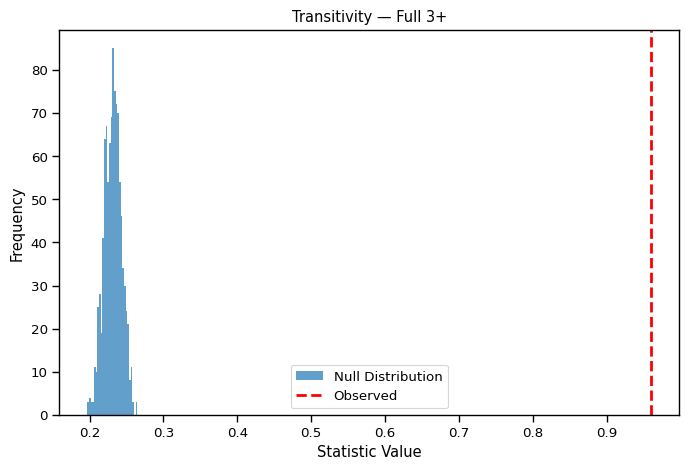


Simulating null for: Full 3+ — Clustering


100%|██████████| 1000/1000 [00:00<00:00, 4836.38it/s]


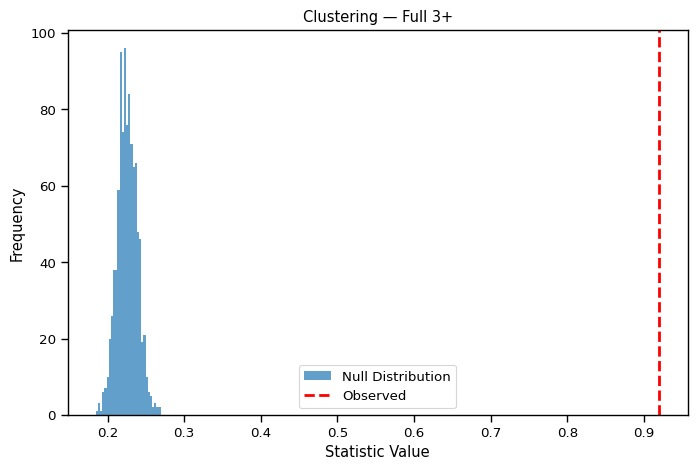


Simulating null for: Full 3+ — Assortativity


100%|██████████| 1000/1000 [00:00<00:00, 4591.53it/s]


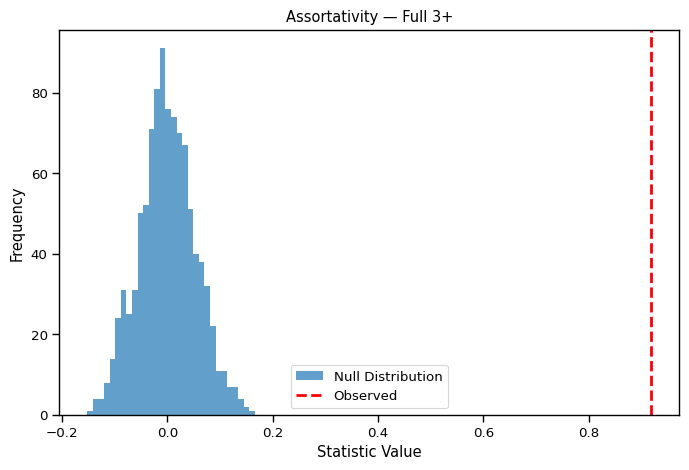


Simulating null for: First Half 3+ — Transitivity


100%|██████████| 1000/1000 [00:00<00:00, 2783.45it/s]


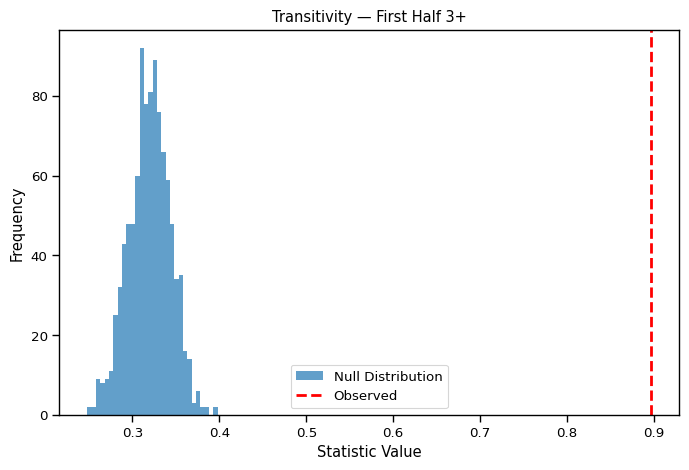


Simulating null for: First Half 3+ — Clustering


100%|██████████| 1000/1000 [00:00<00:00, 2566.58it/s]


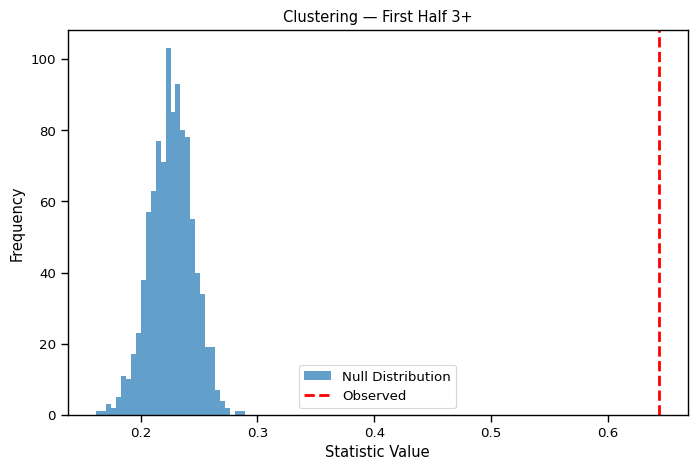


Simulating null for: First Half 3+ — Assortativity


100%|██████████| 1000/1000 [00:00<00:00, 10370.39it/s]


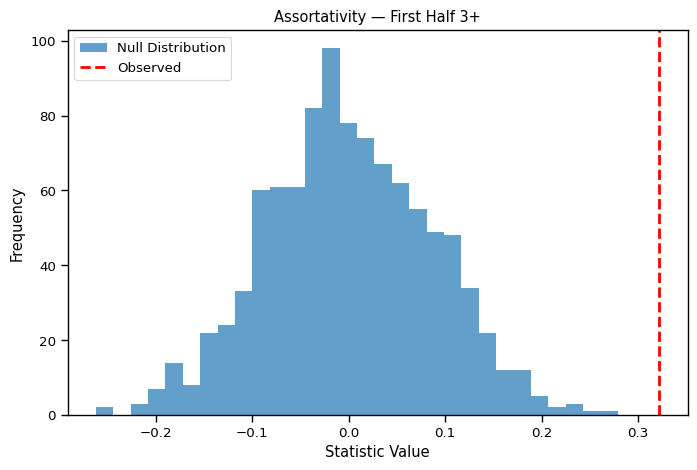


Simulating null for: Second Half 3+ — Transitivity


100%|██████████| 1000/1000 [00:00<00:00, 5418.98it/s]


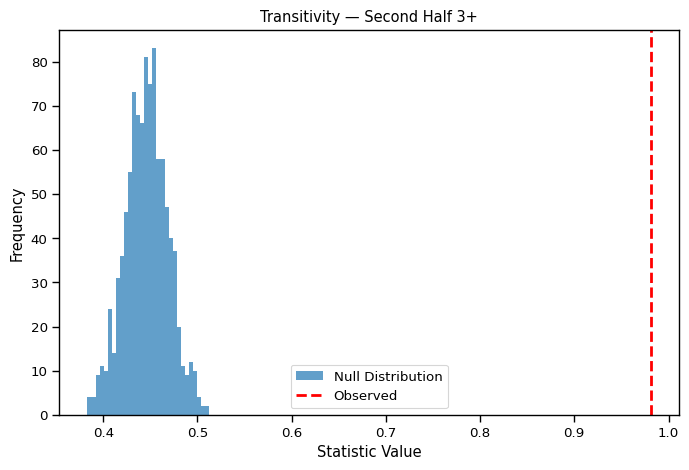


Simulating null for: Second Half 3+ — Clustering


100%|██████████| 1000/1000 [00:00<00:00, 3790.86it/s]


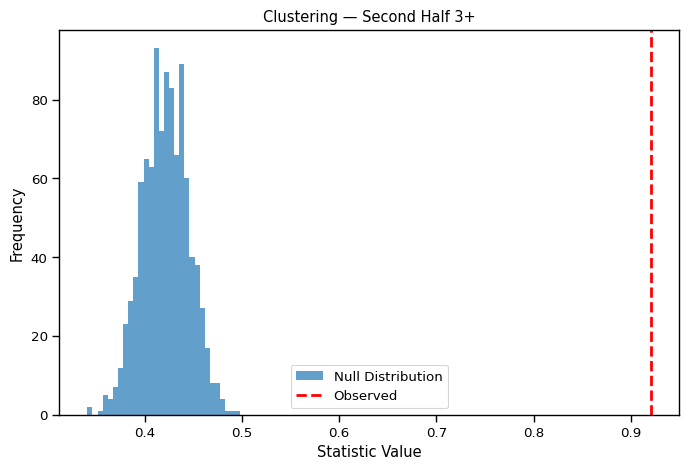


Simulating null for: Second Half 3+ — Assortativity


100%|██████████| 1000/1000 [00:00<00:00, 7721.54it/s]


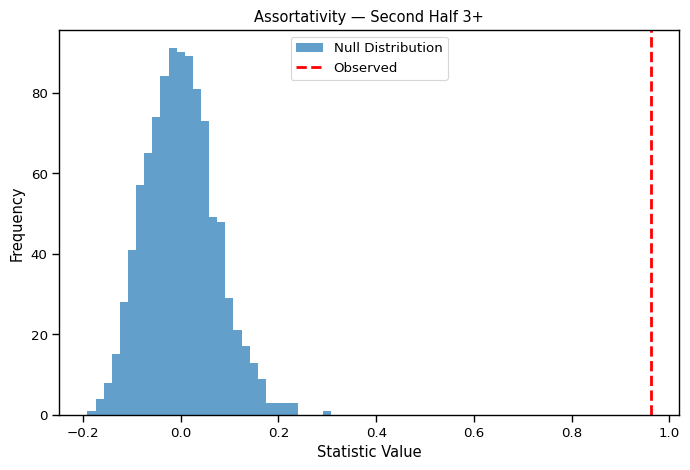


Simulating null for: Full 5+ — Transitivity


100%|██████████| 1000/1000 [00:00<00:00, 5209.63it/s]


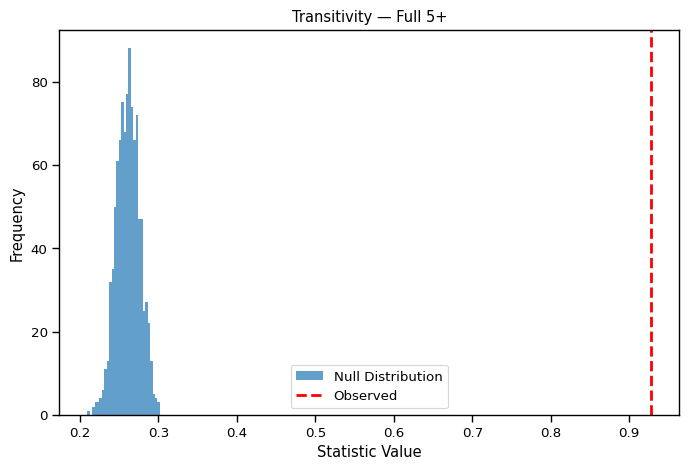


Simulating null for: Full 5+ — Clustering


100%|██████████| 1000/1000 [00:00<00:00, 4183.31it/s]


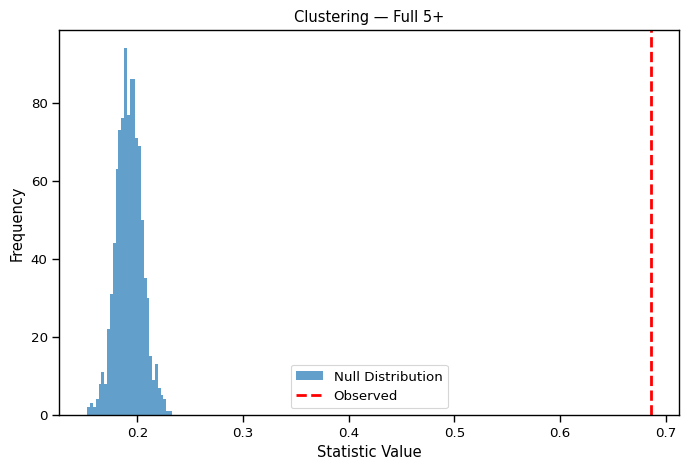


Simulating null for: Full 5+ — Assortativity


100%|██████████| 1000/1000 [00:00<00:00, 7407.59it/s]


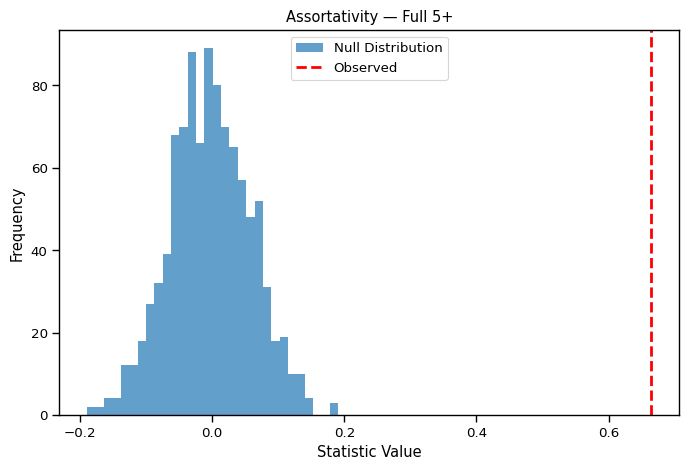


Simulating null for: First Half 5+ — Transitivity


100%|██████████| 1000/1000 [00:00<00:00, 5450.63it/s]


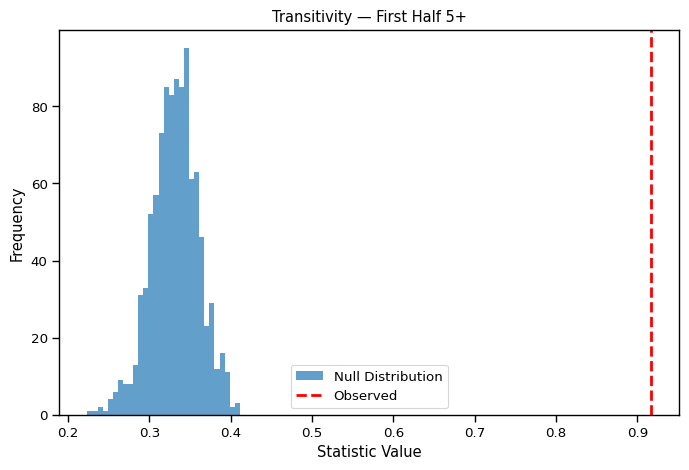


Simulating null for: First Half 5+ — Clustering


100%|██████████| 1000/1000 [00:00<00:00, 6260.52it/s]


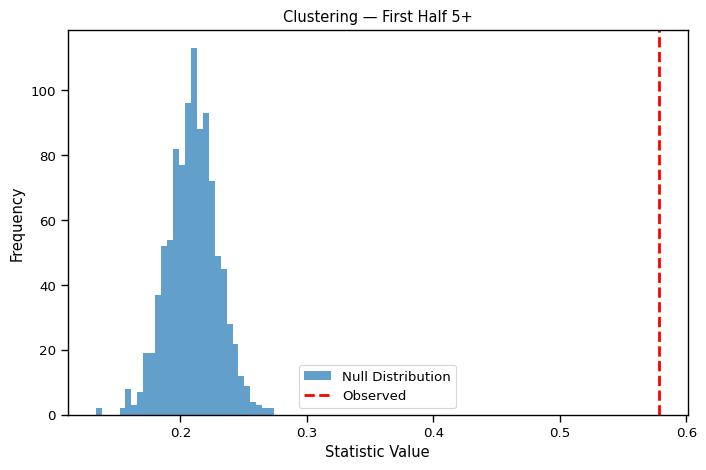


Simulating null for: First Half 5+ — Assortativity


100%|██████████| 1000/1000 [00:00<00:00, 8519.26it/s]


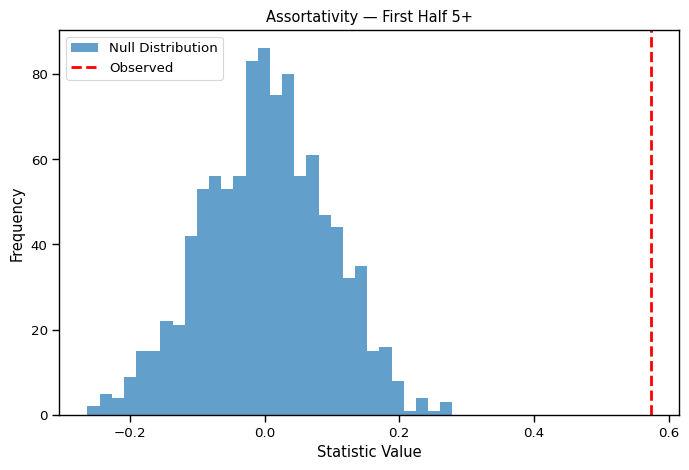


Simulating null for: Second Half 5+ — Transitivity


100%|██████████| 1000/1000 [00:00<00:00, 12816.39it/s]


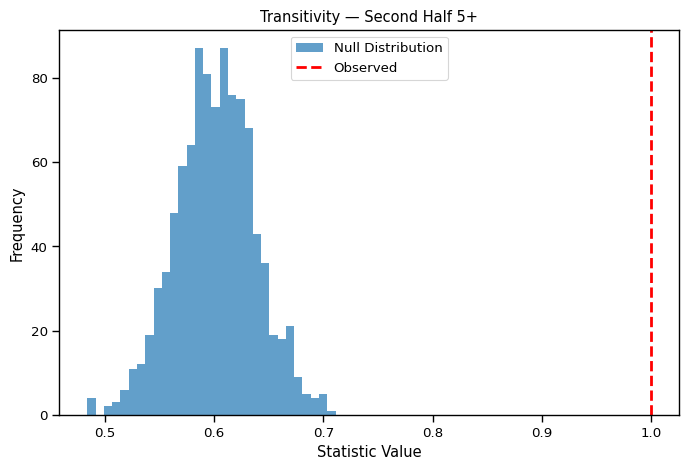


Simulating null for: Second Half 5+ — Clustering


100%|██████████| 1000/1000 [00:00<00:00, 3050.37it/s]


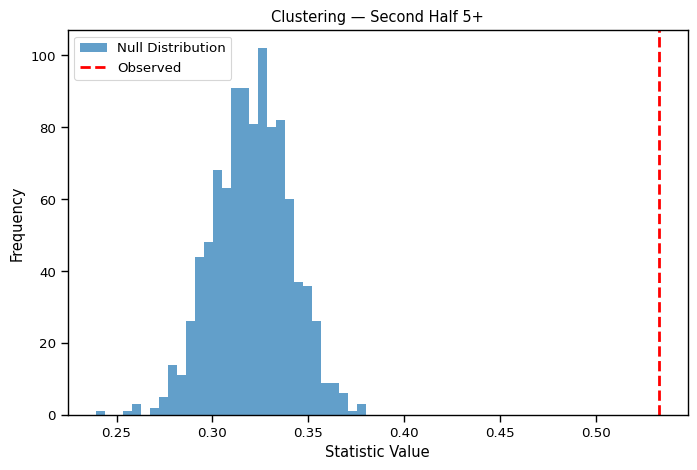


Simulating null for: Second Half 5+ — Assortativity


100%|██████████| 1000/1000 [00:00<00:00, 5838.45it/s]

Skipping plot for Assortativity — Second Half 5+ — no valid data.


In [51]:
# Define the networks (excluding thirds)
from tqdm import tqdm

networks = [
    ("adjacency_matrix_full_3plus.csv", "Full 3+"),
    ("adjacency_matrix_firsthalf_3plus.csv", "First Half 3+"),
    ("adjacency_matrix_secondhalf_3plus.csv", "Second Half 3+"),

    ("adjacency_matrix_full_5plus.csv", "Full 5+"),
    ("adjacency_matrix_firsthalf_5plus.csv", "First Half 5+"),
    ("adjacency_matrix_secondhalf_5plus.csv", "Second Half 5+"),
]

# Define the statistics to simulate and plot
stat_tests = [
    ("Transitivity", lambda g: g.transitivity_undirected()),
    ("Clustering", lambda g: np.mean(g.transitivity_local_undirected(mode="zero"))),
    ("Assortativity", lambda g: g.assortativity_degree())
]

# Loop through networks and stats to generate plots
for path, label in networks:
    for stat_name, stat_func in stat_tests:
        run_null_plot(path, label, stat_name, stat_func)


# Section 6: Figures Used in Thesis (Degree Distribution, Boxplots, Scatterplots, Heatmaps)

Degree Sequence Histogram - No interaction threshold

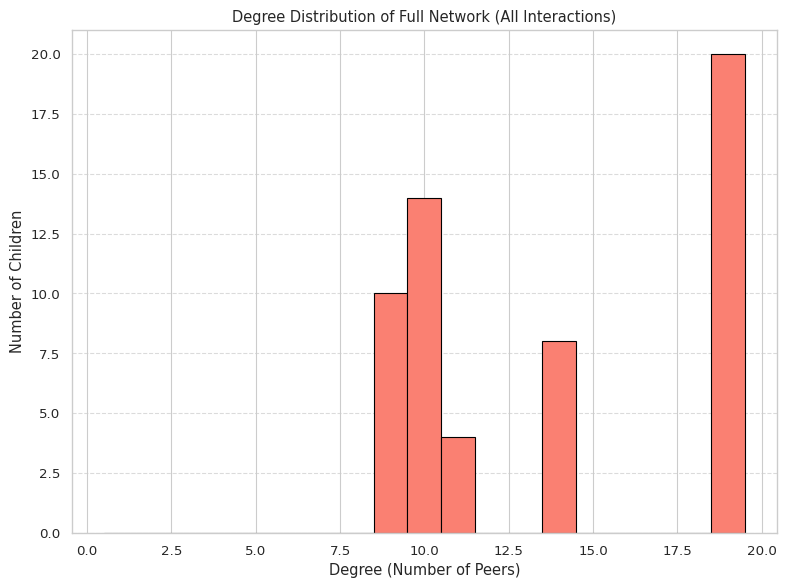

In [14]:
# Install required packages (if needed)
!pip install pandas matplotlib networkx

# Import libraries (if needed)
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the data (if needed)
df = pd.read_csv("partner vocalizations.csv")


# Build undirected dyads
df['pair'] = df.apply(lambda row: tuple(sorted([row['Subject'], row['Partner']])), axis=1)

# Remove duplicate dyads
unique_pairs = df['pair'].drop_duplicates().tolist()

# Create undirected graph
G_all = nx.Graph()
G_all.add_edges_from(unique_pairs)

#Compute node degrees
degrees_all = [degree for node, degree in G_all.degree()]

# Plot degree distribution
plt.figure(figsize=(8, 6))
plt.hist(degrees_all, bins=range(1, max(degrees_all)+2), color='salmon', edgecolor='black', align='left')
plt.title("Degree Distribution of Full Network (All Interactions)")
plt.xlabel("Degree (Number of Peers)")
plt.ylabel("Number of Children")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save figure to file
plt.savefig("degree_histogram_unfiltered.png", dpi=300)
plt.show()


Degree Sequence Histogram - 5+ Interaction Threshold

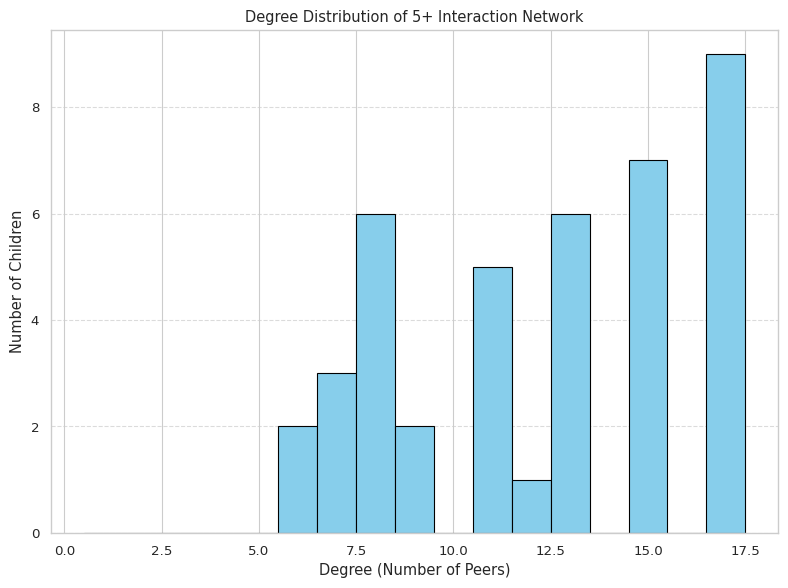

In [15]:
# Install packages (if needed)
!pip install pandas matplotlib networkx

# Import packages (if needed)
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load dataset from folder (if needed)
df = pd.read_csv("partner vocalizations.csv")

# Create undirected pairs
df['pair'] = df.apply(lambda row: tuple(sorted([row['Subject'], row['Partner']])), axis=1)

# Aggregate interaction counts per dyad
pair_counts = df['pair'].value_counts().reset_index()
pair_counts.columns = ['pair', 'interaction_count']

# Apply threshold: only dyads with ≥5 interactions
threshold = 5
filtered_pairs = pair_counts[pair_counts['interaction_count'] >= threshold]

# Extract edge list
edges = filtered_pairs['pair'].tolist()

# Build undirected graph
G = nx.Graph()
G.add_edges_from(edges)

# Extract degrees and plot histogram
degrees = [deg for _, deg in G.degree()]
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=range(1, max(degrees) + 2), color='skyblue', edgecolor='black', align='left')
plt.title("Degree Distribution of 5+ Interaction Network")
plt.xlabel("Degree (Number of Peers)")
plt.ylabel("Number of Children")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save figure
plt.savefig("degree_histogram_5plus.png", dpi=300)
plt.show()


Lead/Lag Vocalization Boxplots



In [16]:
# Load and clean data
df = pd.read_csv("partner vocalizations.csv")
df["specificdiagnosis"] = df["specificdiagnosis"].str.strip().str.title()

#load new package
!pip install statannotations

# Compute mean vocalization scores per subject
subject_voice = df.groupby("Subject").agg({
    "targetLeadVoc_c": "mean",
    "targetLagVoc_c": "mean",
    "specificdiagnosis": "first"
}).reset_index()

# Rename for clarity
subject_voice.rename(columns={
    "targetLeadVoc_c": "AvgLead",
    "targetLagVoc_c": "AvgLag",
    "specificdiagnosis": "Diagnosis"
}, inplace=True)

# Drop subjects missing both lead & lag
subject_voice.dropna(subset=["AvgLead", "AvgLag"], how="all", inplace=True)


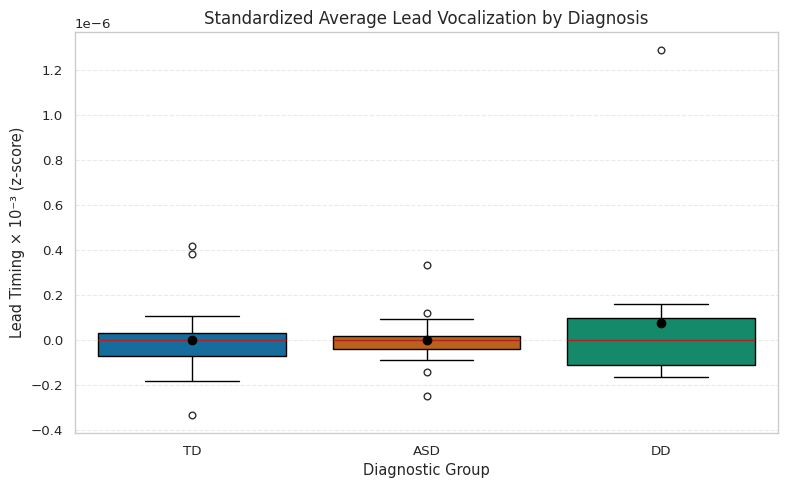

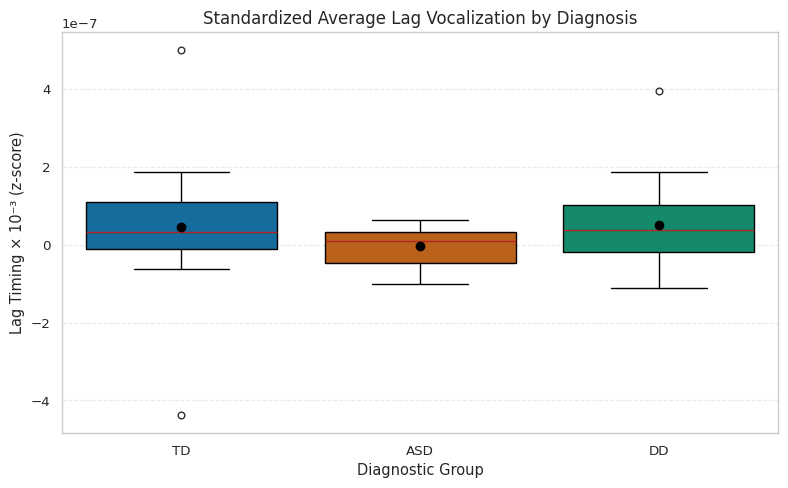

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", context="paper", font_scale=1.1)

# Standardize diagnosis labels
subject_voice["Diagnosis"] = subject_voice["Diagnosis"].replace({
    "Autism": "ASD", "Delay": "DD", "Typical": "TD"
}).str.strip()

# Define order and color palette
order = ['TD', 'ASD', 'DD']
palette = {
    'TD': "#0072B2",   # blue
    'ASD': "#D55E00",  # red-orange
    'DD': "#009E73"    # green
}

# Scale vocalization timing for visualization
subject_voice["AvgLeadPlot"] = subject_voice["AvgLead"] * 1000
subject_voice["AvgLagPlot"] = subject_voice["AvgLag"] * 1000

# --- Figure 1: Lead Vocalizations ---
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="Diagnosis", y="AvgLeadPlot", data=subject_voice,
    order=order, hue="Diagnosis", hue_order=order, palette=palette, legend=False,
    showmeans=True,
    meanprops=dict(marker="o", markerfacecolor="black", markeredgecolor="black"),
    medianprops=dict(color="firebrick"),
    boxprops=dict(edgecolor='black', linewidth=1),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)
plt.title("Standardized Average Lead Vocalization by Diagnosis", fontsize=12)
plt.ylabel("Lead Timing × 10⁻³ (z-score)")
plt.xlabel("Diagnostic Group")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("figure1_lead_final.pdf", dpi=300)
plt.show()

# --- Figure 2: Lag Vocalizations ---
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="Diagnosis", y="AvgLagPlot", data=subject_voice,
    order=order, hue="Diagnosis", hue_order=order, palette=palette, legend=False,
    showmeans=True,
    meanprops=dict(marker="o", markerfacecolor="black", markeredgecolor="black"),
    medianprops=dict(color="firebrick"),
    boxprops=dict(edgecolor='black', linewidth=1),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black')
)
plt.title("Standardized Average Lag Vocalization by Diagnosis", fontsize=12)
plt.ylabel("Lag Timing × 10⁻³ (z-score)")
plt.xlabel("Diagnostic Group")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("figure2_lag_final.pdf", dpi=300)
plt.show()


Lead/Lag Vocalization Scatterplots

In [18]:
# Load centrality file (if needed)
centrality_df = pd.read_csv("degree_centrality_full_5plus.csv")

# Match ID columns for merge
centrality_df.rename(columns={"ID": "Subject"}, inplace=True)

# Merge vocalization and centrality
merged = pd.merge(subject_voice, centrality_df, on="Subject", how="inner")

# Clean diagnosis column (if duplicated)
if "Diagnosis_x" in merged.columns:
    merged["Diagnosis"] = merged["Diagnosis_x"]


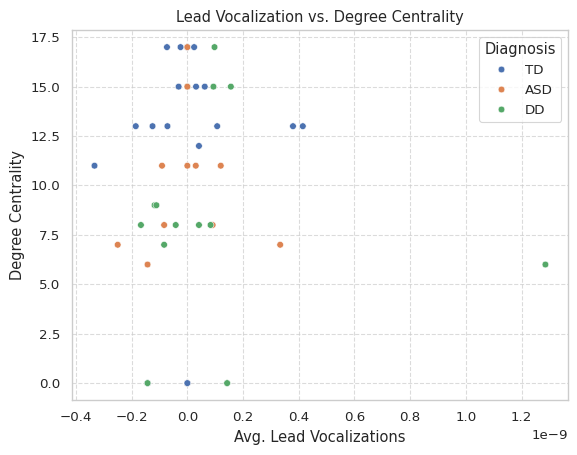

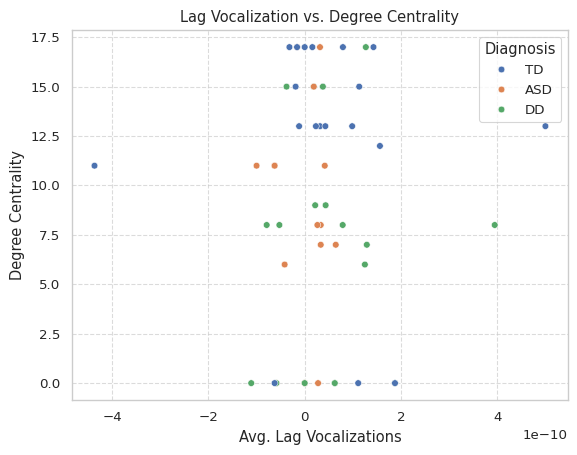

Corr(Lead, Degree): 0.034
Corr(Lag, Degree): 0.035


In [19]:
# Lead Vocalization vs Degree Centrality
sns.scatterplot(x="AvgLead", y="Degree", hue="Diagnosis", data=merged)
plt.title("Lead Vocalization vs. Degree Centrality")
plt.xlabel("Avg. Lead Vocalizations")
plt.ylabel("Degree Centrality")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Lag Vocalization vs Degree Centrality
sns.scatterplot(x="AvgLag", y="Degree", hue="Diagnosis", data=merged)
plt.title("Lag Vocalization vs. Degree Centrality")
plt.xlabel("Avg. Lag Vocalizations")
plt.ylabel("Degree Centrality")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Optional: Correlation coefficients
print("Corr(Lead, Degree):", round(merged["AvgLead"].corr(merged["Degree"]), 3))
print("Corr(Lag, Degree):", round(merged["AvgLag"].corr(merged["Degree"]), 3))


Interaction Heatmaps per Diagnosis Group

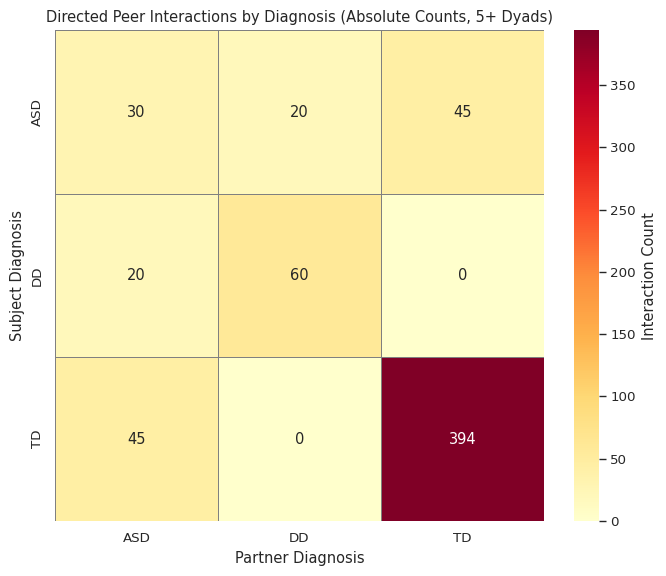

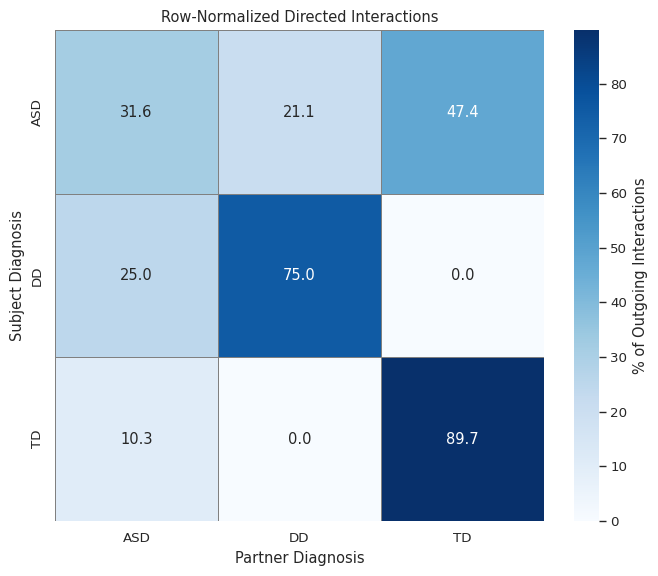

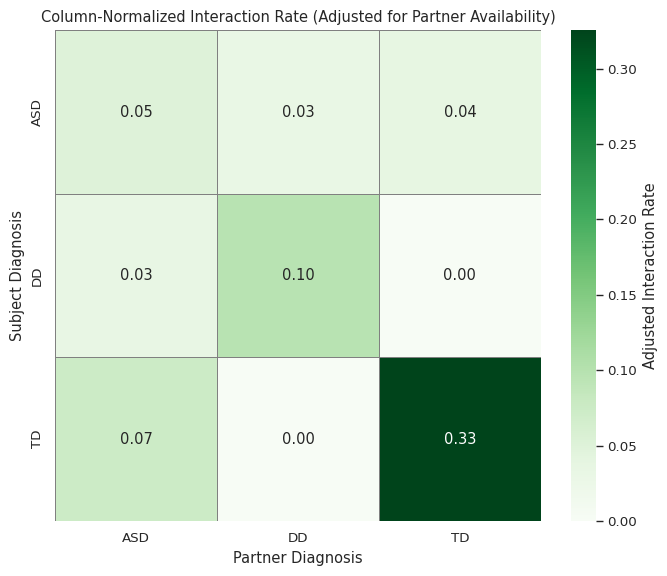

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and clean dataset
df = pd.read_csv("partner vocalizations.csv")
df["specificdiagnosis"] = df["specificdiagnosis"].str.strip().str.title()
df["partnerspecificdiagnosis"] = df["partnerspecificdiagnosis"].str.strip().str.title()

# Map diagnosis labels to short codes
label_map = {"Autism": "ASD", "Delay": "DD", "Typical": "TD"}
df["FromDiag"] = df["specificdiagnosis"].map(label_map)
df["ToDiag"] = df["partnerspecificdiagnosis"].map(label_map)
df = df.dropna(subset=["FromDiag", "ToDiag"])

# Filter: Only dyads with 5+ directed interactions
dyad_counts = df.groupby(["Subject", "Partner"]).size()
valid_pairs = dyad_counts[dyad_counts >= 5].index
df_directed = df.set_index(["Subject", "Partner"]).loc[valid_pairs].reset_index()

# Step 1: Absolute directed interaction matrix
interaction_matrix = df_directed.groupby(["FromDiag", "ToDiag"]).size().unstack(fill_value=0)
labels = ["ASD", "DD", "TD"]
interaction_matrix = interaction_matrix.reindex(index=labels, columns=labels, fill_value=0)

# Step 2: Row-normalized (% of outgoing interactions)
row_norm = interaction_matrix.div(interaction_matrix.sum(axis=1), axis=0) * 100

# Step 3: Column-normalized (adjusted for group size)
group_sizes = df["ToDiag"].value_counts().reindex(labels, fill_value=1)
col_norm = interaction_matrix.div(group_sizes, axis=1)

# Plot 1: Absolute interaction counts (directed)
plt.figure(figsize=(7, 6))
sns.heatmap(interaction_matrix, annot=True, fmt='d', cmap="YlOrRd",
            cbar_kws={'label': 'Interaction Count'},
            linewidths=0.5, linecolor='gray')
plt.title("Directed Peer Interactions by Diagnosis (Absolute Counts, 5+ Dyads)")
plt.xlabel("Partner Diagnosis")
plt.ylabel("Subject Diagnosis")
plt.tight_layout(pad=1.5)
plt.show()

# Plot 2: Row-normalized (% of outgoing interactions)
plt.figure(figsize=(7, 6))
sns.heatmap(row_norm, annot=True, fmt='.1f', cmap="Blues",
            cbar_kws={'label': '% of Outgoing Interactions'},
            linewidths=0.5, linecolor='gray')
plt.title("Row-Normalized Directed Interactions")
plt.xlabel("Partner Diagnosis")
plt.ylabel("Subject Diagnosis")
plt.tight_layout(pad=1.5)
plt.show()

# Plot 3: Column-normalized (per capita received)
plt.figure(figsize=(7, 6))
sns.heatmap(col_norm, annot=True, fmt='.2f', cmap="Greens",
            cbar_kws={'label': 'Adjusted Interaction Rate'},
            linewidths=0.5, linecolor='gray')
plt.title("Column-Normalized Interaction Rate (Adjusted for Partner Availability)")
plt.xlabel("Partner Diagnosis")
plt.ylabel("Subject Diagnosis")
plt.tight_layout(pad=1.5)
plt.show()


# Section 7: Summary

## Thesis Code and Analysis

This repository contains the full code used to reproduce the tables and figures presented in the BSc thesis:

**"Detecting Network Externalities in Preschool Social Networks: Evidence from Inclusive Classrooms"**  
by Julie Demuth, BSc Econometrics and Data Science, University of Amsterdam (2025)

The code includes:
- Data cleaning and diagnostic mapping
- Construction of peer interaction networks
- Descriptive visualizations (degree distributions, boxplots, scatterplots, heatmaps)
- Structural network analysis based on simulation methods from Graham & Pelican (2020)

All figures and results correspond directly to the outputs reported in the main text and appendix of the thesis.
